### Bloco 0
### Preparação do ambiente e montagem do Google Drive

Este bloco:

- Monta o Google Drive no Colab para acesso aos arquivos do corpus.
- Define parâmetros globais reprodutíveis (caminhos e configuração mínima).
- Centraliza o `ROOT_PATH` para evitar inconsistências de path ao longo do notebook.

Observação metodológica:
- A reprodutibilidade depende de paths parametrizados e validações explícitas de acesso ao armazenamento.


In [5]:
from google.colab import drive
from pathlib import Path
import os

# 1) Monta o Google Drive
drive.mount('/content/drive')

# 2) Parâmetros globais do projeto (evitar "strings mágicas" espalhadas)
ROOT_PATH = Path("/content/drive/MyDrive/Processos_Jurídicos")
DATA_PATH = ROOT_PATH / "data"

print("ROOT_PATH:", ROOT_PATH)
print("DATA_PATH:", DATA_PATH)

# 3) Garantir encoding/locale não é possível globalmente no Colab,
# mas registramos a execução para rastreabilidade.
print("Diretório atual:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT_PATH: /content/drive/MyDrive/Processos_Jurídicos
DATA_PATH: /content/drive/MyDrive/Processos_Jurídicos/data
Diretório atual: /content


### Bloco 0.1
### Validação de estrutura de diretórios e acesso

Este bloco:

- Verifica a existência do diretório que contém os processos.
- Realiza diagnóstico básico: quantidade de subpastas (processos) e exemplos.
- Interrompe a execução com erro claro caso o caminho esteja incorreto.

Observação metodológica:
- A unidade amostral do estudo (processo vs. documento) depende desta estrutura.
- Nesta etapa, já registramos quantos processos (pastas) existem para controle amostral.

In [6]:
from pathlib import Path

# DATA_PATH já definido no Bloco 0
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Pasta não encontrada: {DATA_PATH}\n"
        "Verifique se o Drive foi montado e se o caminho está correto."
    )

# Lista somente subpastas (cada uma deve representar um process_id)
process_folders = sorted([p for p in DATA_PATH.iterdir() if p.is_dir()])

print(f"✅ DATA_PATH encontrada: {DATA_PATH}")
print(f"Total de subpastas (processos): {len(process_folders)}")

# Mostra amostra para inspeção
print("\nExemplo de process_id (primeiros 10):")
for p in process_folders[:10]:
    print(" -", p.name)


✅ DATA_PATH encontrada: /content/drive/MyDrive/Processos_Jurídicos/data
Total de subpastas (processos): 412

Exemplo de process_id (primeiros 10):
 - 07000960220238070000
 - 07002005720238079000
 - 07002221820238079000
 - 07004113020228079000
 - 07007647520208070000
 - 07008581820238070000
 - 07008888720228070000
 - 07009661320238079000
 - 07010138420238079000
 - 07010383420238070000


### Bloco 0.2
### Inventário de arquivos por processo e por tipo

Este bloco:

- Percorre recursivamente as subpastas de processos.
- Lista e contabiliza arquivos por extensão (ex.: .txt, .pdf).
- Constrói métricas diagnósticas:
  - total de arquivos,
  - número de processos com pelo menos 1 .txt,
  - número de processos com múltiplos .txt (risco de duplicidade textual).

Observação metodológica:
- A presença de múltiplos documentos por processo pode violar independência amostral
  se não houver regra explícita de seleção (ex.: "usar o último documento", "usar o maior",
  ou "agregar por processo").

In [7]:
from collections import Counter, defaultdict

all_files = []
ext_counter = Counter()
files_by_process = defaultdict(list)

for proc_dir in process_folders:
    for f in proc_dir.rglob("*"):
        if f.is_file():
            all_files.append(f)
            ext_counter[f.suffix.lower()] += 1
            files_by_process[proc_dir.name].append(f)

print(f"Total de arquivos encontrados (todas extensões): {len(all_files)}")
print("Distribuição por extensão:")
for ext, cnt in ext_counter.most_common():
    print(f" - {ext or '[sem_ext]'}: {cnt}")

# Diagnósticos específicos para o corpus textual
txt_processes = [pid for pid, flist in files_by_process.items() if any(f.suffix.lower()==".txt" for f in flist)]
multi_txt_processes = [pid for pid, flist in files_by_process.items() if sum(f.suffix.lower()==".txt" for f in flist) > 1]

print(f"\nProcessos com pelo menos 1 .txt: {len(txt_processes)} / {len(process_folders)}")
print(f"Processos com MAIS DE 1 .txt (atenção para regra de seleção): {len(multi_txt_processes)}")

# Exibe exemplos de processos com múltiplos txt (se existirem)
if multi_txt_processes:
    print("\nExemplos de processos com múltiplos .txt:")
    for pid in multi_txt_processes[:5]:
        txts = [str(f.name) for f in files_by_process[pid] if f.suffix.lower()==".txt"]
        print(" -", pid, "=>", txts)

Total de arquivos encontrados (todas extensões): 798
Distribuição por extensão:
 - .txt: 770
 - .pdf: 28

Processos com pelo menos 1 .txt: 412 / 412
Processos com MAIS DE 1 .txt (atenção para regra de seleção): 335

Exemplos de processos com múltiplos .txt:
 - 07000960220238070000 => ['001_VISUALIZAR_DOCUMENTOS_02_05_2023_10_33_13_AC_RD_O_.txt', '002_VISUALIZAR_DOCUMENTOS_12_01_2023_15_20_21_DECIS_O_.txt']
 - 07002005720238079000 => ['001_VISUALIZAR_DOCUMENTOS_08_05_2023_14_55_23_AC_RD_O_.txt', '002_VISUALIZAR_DOCUMENTOS_16_02_2023_19_09_11_DECIS_O_.txt']
 - 07002221820238079000 => ['001_VISUALIZAR_DOCUMENTOS_31_07_2023_10_59_20_AC_RD_O_.txt', '002_VISUALIZAR_DOCUMENTOS_06_03_2023_15_13_21_DECIS_O_.txt']
 - 07004113020228079000 => ['001_01_06_2023_16_42_48_0700411_30_2022_8_07_9000_1685.txt', '002_VISUALIZAR_DOCUMENTOS_25_04_2023_18_31_25_AC_RD_O_.txt', '003_VISUALIZAR_DOCUMENTOS_13_06_2022_17_07_54_DECIS_O_.txt']
 - 07008581820238070000 => ['001_VISUALIZAR_DOCUMENTOS_09_05_2023_17_42_

### Bloco 0.3
### Construção da base tabular de documentos textuais (metadados)

Este bloco:

- Cria um DataFrame com metadados por arquivo .txt: `process_id`, `file_name`, `file_path`.
- Extrai atributos úteis para auditoria e seleção:
  - tamanho do arquivo (bytes),
  - data de modificação,
  - extensão e padrão do nome.
- Gera estatísticas para suportar a definição da unidade textual do estudo.

Observação metodológica:
- Se houver mais de um .txt por processo, deve-se definir uma regra explícita:
  (i) selecionar 1 documento por processo, ou
  (ii) agregar documentos por processo.
- Sem essa regra, o N efetivo do estudo fica ambíguo e pode inflar significância.


In [8]:
import pandas as pd

# Coleta somente TXT
txt_files = []
for proc_dir in process_folders:
    txt_files.extend(list(proc_dir.rglob("*.txt")))

print(f"Total de arquivos .txt encontrados: {len(txt_files)}")

registros = []
for f in sorted(txt_files):
    process_id = f.parent.name  # pasta do processo
    registros.append({
        "process_id": process_id,
        "file_name": f.name,
        "file_path": str(f),
        "file_size_bytes": f.stat().st_size,
        "file_mtime": pd.to_datetime(f.stat().st_mtime, unit="s"),
    })

df_arquivos = pd.DataFrame(registros)

# Integridade mínima
print("\nAmostra (head):")
display(df_arquivos.head())

print("\nDiagnóstico: documentos por processo (distribuição):")
docs_per_process = df_arquivos.groupby("process_id").size().describe()
print(docs_per_process)

# Exibe processos com mais documentos
top_multi = (
    df_arquivos.groupby("process_id")
    .size()
    .sort_values(ascending=False)
    .head(10)
)
print("\nTop 10 processos com mais .txt:")
print(top_multi)


Total de arquivos .txt encontrados: 770

Amostra (head):


,process_id,file_name,file_path,file_size_bytes,file_mtime
0,07000960220238070000,001_VISUALIZAR_DOCUMENTOS_02_05_2023_10_33_13_...,/content/drive/MyDrive/Processos_Jurídicos/da...,31713,2025-12-03 08:58:38
1,07000960220238070000,002_VISUALIZAR_DOCUMENTOS_12_01_2023_15_20_21_...,/content/drive/MyDrive/Processos_Jurídicos/da...,29262,2025-12-03 08:58:56
2,07002005720238079000,001_VISUALIZAR_DOCUMENTOS_08_05_2023_14_55_23_...,/content/drive/MyDrive/Processos_Jurídicos/da...,13868,2025-12-03 09:26:13
3,07002005720238079000,002_VISUALIZAR_DOCUMENTOS_16_02_2023_19_09_11_...,/content/drive/MyDrive/Processos_Jurídicos/da...,11413,2025-12-03 09:26:28
4,07002221820238079000,001_VISUALIZAR_DOCUMENTOS_31_07_2023_10_59_20_...,/content/drive/MyDrive/Processos_Jurídicos/da...,12235,2025-12-03 07:40:55



Diagnóstico: documentos por processo (distribuição):
count    412.000000
mean       1.868932
std        0.480577
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
dtype: float64

Top 10 processos com mais .txt:
process_id
07350559620238070000    4
07416963720228070000    3
07300320920228070000    3
07017667520238070000    3
07298750220238070000    3
07342261820238070000    3
07271755320238070000    3
07227923220238070000    3
07229768520238070000    3
07358977620238070000    3
dtype: int64


### Bloco 0.4
### Definição operacional da unidade textual e regra de seleção (1 documento por processo)

Este bloco:

- Define explicitamente a unidade amostral do estudo: **processo** (não "arquivo").
- Implementa uma regra de seleção reprodutível para obter **um texto por processo**.
- Mantém rastreabilidade: registra qual arquivo foi escolhido e por quê.

Justificativa metodológica:
- A pergunta de pesquisa (diferença por gênero do julgador) demanda independência aproximada
  das observações. Em bases judiciais, múltiplos documentos por processo podem representar
  o mesmo caso (dependência intra-processo), violando pressupostos de testes estatísticos.
- Assim, adotamos **1 documento textual por processo** como unidade analítica primária.

Regra de seleção (auditável):
- Escolher, por processo, o arquivo .txt com maior **data de modificação (mtime)**.
- Critério de desempate: maior **tamanho do arquivo (bytes)**.

Saídas:
- `df_docs_processo`: 1 linha por processo, com metadados do arquivo selecionado.
- Relatórios diagnósticos: quantos processos ficaram sem .txt; quantos tinham múltiplos .txt.


In [9]:
import pandas as pd

# Pré-condição: df_arquivos existe do Bloco 0.3 e contém:
# process_id, file_name, file_path, file_size_bytes, file_mtime

# 1) Diagnóstico: processos sem TXT (se a origem for construída só com txt, este N será 0)
all_process_ids = set([p.name for p in process_folders])
txt_process_ids = set(df_arquivos["process_id"].unique())

missing_txt = sorted(list(all_process_ids - txt_process_ids))

print(f"Total de processos (subpastas): {len(all_process_ids)}")
print(f"Processos com pelo menos 1 .txt: {len(txt_process_ids)}")
print(f"Processos SEM .txt: {len(missing_txt)}")

if missing_txt:
    print("\nExemplos de processos sem .txt (primeiros 10):")
    for pid in missing_txt[:10]:
        print(" -", pid)

# 2) Quantidade de TXT por processo
txt_counts = df_arquivos.groupby("process_id").size()
multi_txt = txt_counts[txt_counts > 1].sort_values(ascending=False)

print(f"\nProcessos com MAIS DE 1 .txt: {len(multi_txt)}")
if len(multi_txt) > 0:
    print("Exemplos (top 10):")
    print(multi_txt.head(10))

# 3) Regra de seleção: maior mtime; desempate por maior tamanho
df_docs_processo = (
    df_arquivos
    .sort_values(["process_id", "file_mtime", "file_size_bytes"], ascending=[True, False, False])
    .groupby("process_id", as_index=False)
    .head(1)
    .reset_index(drop=True)
)

# 4) Auditoria: confirmar 1 linha por processo com TXT
print("\n✅ Base final (1 documento por processo):")
print("Linhas:", len(df_docs_processo))
print("Processos únicos:", df_docs_processo["process_id"].nunique())

# 5) Registrar distribuição de tamanhos (detectar arquivos vazios/curtos)
print("\nDistribuição de tamanho dos textos selecionados (bytes):")
print(df_docs_processo["file_size_bytes"].describe())

# 6) Exibir amostra
display(df_docs_processo.head(10))


Total de processos (subpastas): 412
Processos com pelo menos 1 .txt: 412
Processos SEM .txt: 0

Processos com MAIS DE 1 .txt: 335
Exemplos (top 10):
process_id
07350559620238070000    4
07387664620228070000    3
07416963720228070000    3
07041259520238070000    3
07330457920238070000    3
07147127920238070000    3
07176322620238070000    3
07271755320238070000    3
07178046520238070000    3
07133192220238070000    3
dtype: int64

✅ Base final (1 documento por processo):
Linhas: 412
Processos únicos: 412

Distribuição de tamanho dos textos selecionados (bytes):
count      412.000000
mean      9919.407767
std       6757.609699
min        856.000000
25%       4813.500000
50%       8544.500000
75%      13096.750000
max      50734.000000
Name: file_size_bytes, dtype: float64


,process_id,file_name,file_path,file_size_bytes,file_mtime
0,07000960220238070000,002_VISUALIZAR_DOCUMENTOS_12_01_2023_15_20_21_...,/content/drive/MyDrive/Processos_Jurídicos/da...,29262,2025-12-03 08:58:56
1,07002005720238079000,002_VISUALIZAR_DOCUMENTOS_16_02_2023_19_09_11_...,/content/drive/MyDrive/Processos_Jurídicos/da...,11413,2025-12-03 09:26:28
2,07002221820238079000,002_VISUALIZAR_DOCUMENTOS_06_03_2023_15_13_21_...,/content/drive/MyDrive/Processos_Jurídicos/da...,7317,2025-12-03 07:41:09
3,07004113020228079000,003_VISUALIZAR_DOCUMENTOS_13_06_2022_17_07_54_...,/content/drive/MyDrive/Processos_Jurídicos/da...,2155,2025-12-03 07:40:24
4,07007647520208070000,001_VISUALIZAR_DOCUMENTOS_11_03_2020_17_44_12_...,/content/drive/MyDrive/Processos_Jurídicos/da...,22064,2025-12-03 05:53:51
5,07008581820238070000,002_VISUALIZAR_DOCUMENTOS_17_01_2023_17_42_11_...,/content/drive/MyDrive/Processos_Jurídicos/da...,12650,2025-12-03 09:11:29
6,07008888720228070000,002_VISUALIZAR_DOCUMENTOS_27_01_2022_15_40_28_...,/content/drive/MyDrive/Processos_Jurídicos/da...,4731,2025-12-03 10:23:00
7,07009661320238079000,002_VISUALIZAR_DOCUMENTOS_16_05_2023_12_31_44_...,/content/drive/MyDrive/Processos_Jurídicos/da...,41301,2025-12-03 06:12:11
8,07010138420238079000,002_VISUALIZAR_DOCUMENTOS_25_05_2023_06_49_11_...,/content/drive/MyDrive/Processos_Jurídicos/da...,3893,2025-12-03 06:47:22
9,07010383420238070000,002_VISUALIZAR_DOCUMENTOS_19_01_2023_17_45_47_...,/content/drive/MyDrive/Processos_Jurídicos/da...,13548,2025-12-03 07:00:02


### Bloco 1 — Leitura segura dos arquivos .txt, auditoria e criação do dataset bruto em Parquet

Este bloco:

- Percorre as subpastas da pasta raiz onde estão os processos.
- Localiza arquivos `.txt` **apenas dentro de subpastas de processos** (evita capturar lixo em `data/`).
- Lê o conteúdo textual com estratégia de encoding auditável (sem perda silenciosa não rastreada).
- Constrói um DataFrame com:
  - `process_id`: ID do processo (nome da subpasta do processo)
  - `file_name`: nome do arquivo `.txt`
  - `file_path`: caminho completo
  - `file_size_bytes`: tamanho (bytes) para controle de qualidade
  - `file_mtime`: data de modificação do arquivo (para seleção posterior)
  - `text_raw`: texto bruto do arquivo
- Gera diagnósticos de integridade (processos sem txt, múltiplos txt, textos vazios/curtos).
- Salva o dataset bruto em Parquet para etapas posteriores (limpeza/extração/modelagem).

Observação metodológica:
- Este bloco NÃO define a unidade final (processo vs documento). Ele produz a base bruta
  e diagnósticos necessários para que a regra seja escolhida explicitamente.


In [10]:
# ============================================
# Bloco 1 — Ler arquivos .txt com auditoria e salvar dataset bruto em Parquet
# ============================================

# 0) Imports padrão
import os                               # operações de sistema e paths
import pandas as pd                     # dataframe e IO Parquet
from pathlib import Path                # paths robustos
from collections import Counter         # contagens diagnósticas

# 1) Definir o caminho raiz onde estão as pastas dos processos
#    IMPORTANTE: use o mesmo padrão parametrizado dos blocos anteriores, se existir.
folder_path = Path("/content/drive/MyDrive/Processos_Jurídicos/data")

# 2) Definir o caminho de saída do arquivo Parquet consolidado
output_dir = Path("/content/drive/MyDrive/Processos_Jurídicos/datasets")
output_dir.mkdir(parents=True, exist_ok=True)  # cria diretório, se necessário
output_parquet_path = output_dir / "tjdf_textos_brutos.parquet"

# 3) Validar existência do diretório de entrada
if not folder_path.exists():
    raise FileNotFoundError(
        f"Pasta raiz não encontrada: {folder_path}\n"
        "Verifique se o Google Drive foi montado e se o caminho está correto."
    )

print(f"Pasta raiz dos processos: {folder_path}")
print(f"Caminho do Parquet de saída: {output_parquet_path}")

# 4) Identificar subpastas de processos (unidade estrutural esperada)
#    - Isso impede capturar arquivos .txt diretamente dentro de `data/` (o problema do process_id='data').
process_folders = sorted([p for p in folder_path.iterdir() if p.is_dir()])

print(f"Total de subpastas (processos): {len(process_folders)}")

# 5) Percorrer cada processo e coletar SOMENTE arquivos .txt dentro dele
txt_files = []  # lista final de arquivos txt válidos
for proc_dir in process_folders:
    # rglob("*.txt") busca recursivamente dentro da subpasta do processo
    txt_files.extend(list(proc_dir.rglob("*.txt")))

print(f"Total de arquivos .txt encontrados (somente dentro de processos): {len(txt_files)}")

# 6) Função de leitura robusta de texto com auditoria mínima de encoding
def read_text_with_fallback(path_txt: Path):
    """
    Lê texto tentando encodings comuns no contexto PT-BR.
    Retorna: (texto, encoding_usado, houve_erro)
    """
    # lista de encodings candidatos (ordem importa)
    encodings_try = ["utf-8", "utf-8-sig", "latin-1", "cp1252"]

    # tenta ler com cada encoding
    for enc in encodings_try:
        try:
            # errors='strict' para NÃO perder informação silenciosamente
            # (se falhar, tentamos o próximo encoding)
            with open(path_txt, "r", encoding=enc, errors="strict") as f:
                return f.read(), enc, False
        except Exception:
            continue

    # último recurso: ler com substituição (auditável) para não travar pipeline
    # IMPORTANTÍSSIMO: aqui reconhecemos que houve perda/substituição.
    with open(path_txt, "r", encoding="utf-8", errors="replace") as f:
        return f.read(), "utf-8(errors=replace)", True

# 7) Montar registros com metadados + texto
registros = []               # lista de dicionários para DataFrame
encoding_counter = Counter() # contagem de encodings utilizados
errors_counter = 0           # contagem de leituras com fallback (houve_erro=True)

for i, full_path in enumerate(sorted(txt_files), start=1):
    # 7.1) process_id -> nome da pasta do processo (pai imediato do arquivo)
    process_id = full_path.parent.name

    # 7.2) file_name -> nome do arquivo
    file_name = full_path.name

    # 7.3) Ler texto com fallback auditável
    text_raw, enc_used, had_error = read_text_with_fallback(full_path)

    # 7.4) Atualizar contadores diagnósticos
    encoding_counter[enc_used] += 1
    if had_error:
        errors_counter += 1

    # 7.5) Coletar metadados de arquivo para auditoria e seleção posterior
    stat = full_path.stat()  # estatísticas do arquivo (tamanho, mtime, etc.)
    file_size_bytes = stat.st_size
    file_mtime = pd.to_datetime(stat.st_mtime, unit="s")

    # 7.6) Adicionar registro ao dataset bruto
    registros.append({
        "process_id": process_id,
        "file_name": file_name,
        "file_path": str(full_path),
        "file_size_bytes": file_size_bytes,
        "file_mtime": file_mtime,
        "text_raw": text_raw,
        "encoding_used": enc_used,
        "encoding_fallback": had_error,
    })

    # 7.7) Log de progresso a cada 100 arquivos
    if i % 100 == 0:
        print(f"{i} arquivos processados...")

print(f"\nTotal de registros carregados: {len(registros)}")
print(f"Leituras com fallback/substituição (potencial perda): {errors_counter}")

print("\nDistribuição de encodings utilizados:")
for k, v in encoding_counter.most_common():
    print(f" - {k}: {v}")

# 8) Criar DataFrame a partir dos registros
df_textos = pd.DataFrame(registros)

# 9) Diagnósticos de integridade fundamentais
# 9.1) Detectar textos vazios ou muito curtos (indicativo de export ruim ou arquivo errado)
df_textos["text_len_chars"] = df_textos["text_raw"].astype(str).str.len()

n_empty = int((df_textos["text_len_chars"] == 0).sum())
n_short = int((df_textos["text_len_chars"] < 200).sum())  # limiar inicial (ajustável)

print("\nDiagnóstico de qualidade textual:")
print(f" - Textos vazios (0 chars): {n_empty}")
print(f" - Textos muito curtos (<200 chars): {n_short}")

# 9.2) Distribuição de documentos por processo (aqui vocês ENXERGAM o problema de múltiplos txt)
docs_per_process = df_textos.groupby("process_id").size().sort_values(ascending=False)

print("\nTop 10 processos com mais .txt:")
print(docs_per_process.head(10))

print("\nResumo estatístico de docs por processo:")
print(docs_per_process.describe())

# 9.3) Checagem explícita do bug anterior: process_id não pode ser 'data'
if (df_textos["process_id"] == "data").any():
    raise ValueError(
        "Encontrado process_id='data'. Isso indica arquivos .txt capturados fora das subpastas de processo.\n"
        "Corrija a estrutura/seleção (este bloco já tenta impedir isso)."
    )

# 10) Amostra do DataFrame
print("\nAmostra do DataFrame resultante:")
display(df_textos.head(5))

# 11) Salvar em Parquet (base bruta)
df_textos.to_parquet(output_parquet_path, index=False)

print(f"\n✅ Arquivo Parquet salvo com sucesso em:\n{output_parquet_path}")


Pasta raiz dos processos: /content/drive/MyDrive/Processos_Jurídicos/data
Caminho do Parquet de saída: /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_textos_brutos.parquet
Total de subpastas (processos): 412
Total de arquivos .txt encontrados (somente dentro de processos): 770
100 arquivos processados...
200 arquivos processados...
300 arquivos processados...
400 arquivos processados...
500 arquivos processados...
600 arquivos processados...
700 arquivos processados...

Total de registros carregados: 770
Leituras com fallback/substituição (potencial perda): 0

Distribuição de encodings utilizados:
 - utf-8: 770

Diagnóstico de qualidade textual:
 - Textos vazios (0 chars): 0
 - Textos muito curtos (<200 chars): 0

Top 10 processos com mais .txt:
process_id
07350559620238070000    4
07416963720228070000    3
07300320920228070000    3
07017667520238070000    3
07298750220238070000    3
07342261820238070000    3
07271755320238070000    3
07227923220238070000    3
0722976852023

,process_id,file_name,file_path,file_size_bytes,file_mtime,text_raw,encoding_used,encoding_fallback,text_len_chars
0,07000960220238070000,001_VISUALIZAR_DOCUMENTOS_02_05_2023_10_33_13_...,/content/drive/MyDrive/Processos_Jurídicos/da...,31713,2025-12-03 08:58:38,Poder Judiciário da União\nTRIBUNAL DE JUSTIÇA...,utf-8,False,30508
1,07000960220238070000,002_VISUALIZAR_DOCUMENTOS_12_01_2023_15_20_21_...,/content/drive/MyDrive/Processos_Jurídicos/da...,29262,2025-12-03 08:58:56,Poder Judiciário da União\n\nTribunal de Justi...,utf-8,False,28178
2,07002005720238079000,001_VISUALIZAR_DOCUMENTOS_08_05_2023_14_55_23_...,/content/drive/MyDrive/Processos_Jurídicos/da...,13868,2025-12-03 09:26:13,Poder Judiciário da União\nTRIBUNAL DE JUSTIÇA...,utf-8,False,13205
3,07002005720238079000,002_VISUALIZAR_DOCUMENTOS_16_02_2023_19_09_11_...,/content/drive/MyDrive/Processos_Jurídicos/da...,11413,2025-12-03 09:26:28,Órgão: 3ª Turma Cível\n\n\nEspécie: AGRAVO DE ...,utf-8,False,10939
4,07002221820238079000,001_VISUALIZAR_DOCUMENTOS_31_07_2023_10_59_20_...,/content/drive/MyDrive/Processos_Jurídicos/da...,12235,2025-12-03 07:40:55,Poder Judiciário da União\nTRIBUNAL DE JUSTIÇA...,utf-8,False,11783



✅ Arquivo Parquet salvo com sucesso em:
/content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_textos_brutos.parquet


### Bloco 2 — Pré-processamento e criação de rótulos fracos conservadores (`decisao` x `outro` x `indefinido`)

Este bloco:

- Carrega o Parquet bruto criado no Bloco 1 (`tjdf_textos_brutos.parquet`).
- Remove registros inválidos:
  - textos nulos/vazios/curtos,
  - entradas que não representam processos (ex.: `process_id="data"`), que indicam lixo estrutural.
- Cria colunas auxiliares normalizadas (maiúsculas e sem acentos) para busca de padrões.
- Aplica regras de weak labeling **conservadoras**:
  - "decisao": apenas quando houver evidência forte (padrões típicos de dispositivo decisório e/ou cabeçalho de decisão).
  - "outro": quando houver evidência forte de peça administrativa/protocolo/petição/ofício/certidão.
  - "indefinido": quando não houver evidência suficiente (evita falso-positivo).
- Registra, para auditoria:
  - `label_weak`,
  - `label_reason` (motivo textual),
  - `label_confidence` (alta/média/baixa).

Saídas:
- Parquet `tjdf_textos_weaklabels.parquet` com colunas originais + auxiliares + rótulos.
- Diagnósticos: distribuição de rótulos e amostras por classe para inspeção manual.


In [16]:
# ============================================
# Bloco 2 — Pré-processamento + rótulos fracos conservadores (decisao x outro x indefinido)
# ============================================

# 0) Imports
import os                                  # paths e diretórios
import re                                  # regex (padrões)
import pandas as pd                        # DataFrame
import numpy as np                         # operações vetoriais
import unicodedata                         # normalização de acentos

# 1) Definir caminhos de entrada e saída (parametrizados)
base_dir = "/content/drive/MyDrive/Processos_Jurídicos"
input_parquet_path = os.path.join(base_dir, "datasets", "tjdf_textos_brutos.parquet")
output_parquet_path = os.path.join(base_dir, "datasets", "tjdf_textos_weaklabels.parquet")

print(f"Caminho de entrada (Parquet bruto): {input_parquet_path}")
print(f"Caminho de saída (Parquet com rótulos fracos): {output_parquet_path}")

# 2) Carregar dataset bruto
df = pd.read_parquet(input_parquet_path)
print(f"\nRegistros carregados: {len(df)}")
print("\nColunas disponíveis:")
print(df.columns)

# 3) Garantias de tipo e limpeza mínima de texto
#    - Evitar cast direto para str sem controle: preserva NaN como NaN e trata depois.
df["text_raw"] = df["text_raw"].fillna("")
df["file_name"] = df["file_name"].fillna("")
df["process_id"] = df["process_id"].fillna("")

# 4) Remover registros com textos vazios/curtos
#    - 10 caracteres é um limiar muito permissivo; use um corte mais defensável.
#    - Aqui usamos 200 chars como triagem inicial (ajustável conforme inspeção).
df["text_length"] = df["text_raw"].astype(str).str.len()
df = df[df["text_length"] >= 200].copy()

print(f"\nRegistros após remoção de textos curtos (<200 chars): {len(df)}")

# 5) Remover "lixo estrutural" explícito
#    - process_id='data' apareceu no resultado; isso NÃO é processo judicial.
#    - Mantemos regra geral: process_id deve ser majoritariamente numérico e com comprimento esperado.
#      (sem impor tamanho fixo, mas garantindo que não é um nome de pasta genérico).
df["process_id_str"] = df["process_id"].astype(str).str.strip()

# 5.1) Filtrar entradas evidentemente inválidas (ex.: 'data')
df = df[df["process_id_str"].str.lower() != "data"].copy()

# 5.2) Filtrar process_id que não seja "principalmente numérico"
#      - Isso reduz capturas acidentais e melhora a validade do corpus.
df = df[df["process_id_str"].str.match(r"^\d{8,}$", na=False)].copy()

print(f"Registros após remoção de process_id inválidos: {len(df)}")

# 6) Normalização textual para busca de padrões
def normalize_upper_noaccents(s: str) -> str:
    """
    Converte para maiúsculas e remove acentos para padronizar buscas.
    """
    s = str(s).upper()
    s = "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )
    return s

# 6.1) Criar colunas normalizadas (nome e texto)
df["file_name_norm"] = df["file_name"].map(normalize_upper_noaccents)
df["text_norm"] = df["text_raw"].map(normalize_upper_noaccents)

# 7) Definir padrões (CONSERVADORES) de decisão e outros documentos
# 7.1) Padrões fortes de "decisão" no TEXTO (dispositivo decisório e estrutura típica)
patterns_decisao_texto_strong = [
    r"\bISTO\s+(?:POSTO|EXPOSTO)\b",
    r"\bANTE\s+O\s+EXPOSTO\b",
    r"\bJULGO\s+(PROCEDENTE|IMPROCEDENTE|PARCIALMENTE\s+PROCEDENTE)\b",
    r"\bCONCEDO\s+A\s+SEGURANCA\b",
    r"\bNEGO\s+PROVIMENTO\b",
    r"\bDOU\s+PROVIMENTO\b",
    r"\bACORDAO\b",        # sem acento (normalizado)
    r"\bSENTENCA\b",       # sem acento (normalizado)
    r"\bDECISAO\b",        # sem acento (normalizado)
]

# 7.2) Padrões fortes de "decisão" no NOME DO ARQUIVO
patterns_decisao_nome_strong = [
    r"\bAC_RD_O\b",        # padrão observado em acórdãos com encoding ruim
    r"\bACORDAO\b",
    r"\bSENTENCA\b",
    r"\bDECISAO\b",
]

# 7.3) Padrões fortes de "outro documento"
patterns_outro_texto_strong = [
    r"\bCERTIDAO\b",
    r"\bOFICIO\b",
    r"\bPETICAO\b",
    r"\bREQUERIMENTO\b",
    r"\bCOMUNICO\b",
    r"\bINTIMACAO\b",
    r"\bMANIFESTACAO\b",
    r"\bJUNTADA\b",
]

patterns_outro_nome_strong = [
    r"\bOFICIO\b",
    r"\bCERTIDAO\b",
    r"\bPETICAO\b",
    r"\bINTIMACAO\b",
    r"\bCOMPROVANTE\b",
]

# 8) Função auxiliar sem "grupos" no regex (remove o warning e é mais correto)
def has_any_pattern(series: pd.Series, patterns) -> pd.Series:
    """
    Retorna Series booleana indicando se qualquer padrão ocorre.
    Usa regex com grupos NÃO capturantes (?: ) para evitar warnings.
    """
    if not patterns:
        return pd.Series(False, index=series.index)

    regex = "(?:" + "|".join(patterns) + ")"
    return series.str.contains(regex, na=False, regex=True)

# 9) Gerar sinais booleanos
df["decisao_texto_strong"] = has_any_pattern(df["text_norm"], patterns_decisao_texto_strong)
df["decisao_nome_strong"] = has_any_pattern(df["file_name_norm"], patterns_decisao_nome_strong)

df["outro_texto_strong"] = has_any_pattern(df["text_norm"], patterns_outro_texto_strong)
df["outro_nome_strong"] = has_any_pattern(df["file_name_norm"], patterns_outro_nome_strong)

# 10) Regras de weak label (conservadoras e explicáveis)
#     - "decisao" apenas se houver evidência forte, priorizando texto (mais confiável que nome).
#     - "outro" se houver evidência forte e não houver evidência de decisão.
cond_decisao = df["decisao_texto_strong"] | df["decisao_nome_strong"]
cond_outro = (~cond_decisao) & (df["outro_texto_strong"] | df["outro_nome_strong"])

df["label_weak"] = np.select(
    [cond_decisao, cond_outro],
    ["decisao", "outro"],
    default="indefinido"
)

# 11) Motivo e confiança (auditoria)
#     - confiança alta: decisão detectada no TEXTO (padrão forte de dispositivo/estrutura)
#     - confiança média: decisão só no NOME (mais frágil)
#     - confiança alta para "outro" quando detectado no texto
df["label_confidence"] = "baixa"

# Índices onde label_weak == "decisao"
idx_decisao = df.index[df["label_weak"] == "decisao"]

# Define confiança para "decisao" apenas nas linhas selecionadas
df.loc[idx_decisao, "label_confidence"] = np.where(
    df.loc[idx_decisao, "decisao_texto_strong"],
    "alta",
    "media"
)

# Índices onde label_weak == "outro"
idx_outro = df.index[df["label_weak"] == "outro"]

# Define confiança para "outro" apenas nas linhas selecionadas
df.loc[idx_outro, "label_confidence"] = np.where(
    df.loc[idx_outro, "outro_texto_strong"],
    "alta",
    "media"
)

# 11.1) Registrar "motivo" textual (explicabilidade)
df["label_reason"] = "nenhum_padrao_forte"

df.loc[idx_decisao, "label_reason"] = np.where(
    df.loc[idx_decisao, "decisao_texto_strong"],
    "padrao_forte_no_texto",
    "padrao_no_nome_arquivo"
)

df.loc[idx_outro, "label_reason"] = np.where(
    df.loc[idx_outro, "outro_texto_strong"],
    "padrao_forte_no_texto",
    "padrao_no_nome_arquivo"
)

# 12) Diagnósticos: distribuição dos rótulos e amostras estratificadas
print("\nDistribuição dos rótulos fracos (label_weak):")
print(df["label_weak"].value_counts(dropna=False))

print("\nDistribuição por confiança (label_confidence):")
print(df["label_confidence"].value_counts(dropna=False))

# 12.1) Amostras para inspeção manual (essencial para estimar precisão do weak label)
def show_examples(df_in, label, n=10):
    sample = df_in[df_in["label_weak"] == label][["process_id", "file_name", "label_confidence", "label_reason"]].head(n)
    print(f"\nExemplos de '{label}':")
    print(sample)

show_examples(df, "decisao", n=10)
show_examples(df, "outro", n=10)
show_examples(df, "indefinido", n=10)

# 13) Salvar dataset com rótulos fracos
df.to_parquet(output_parquet_path, index=False)

print(f"\n✅ Arquivo Parquet com rótulos fracos salvo em:\n{output_parquet_path}")


Caminho de entrada (Parquet bruto): /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_textos_brutos.parquet
Caminho de saída (Parquet com rótulos fracos): /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_textos_weaklabels.parquet

Registros carregados: 770

Colunas disponíveis:
Index(['process_id', 'file_name', 'file_path', 'file_size_bytes', 'file_mtime',
       'text_raw', 'encoding_used', 'encoding_fallback', 'text_len_chars'],
      dtype='object')

Registros após remoção de textos curtos (<200 chars): 770
Registros após remoção de process_id inválidos: 770


/tmp/ipython-input-3152000474.py:123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return series.str.contains(regex, na=False, regex=True)



Distribuição dos rótulos fracos (label_weak):
label_weak
decisao       760
indefinido      5
outro           5
Name: count, dtype: int64

Distribuição por confiança (label_confidence):
label_confidence
alta     765
baixa      5
Name: count, dtype: int64

Exemplos de 'decisao':
             process_id                                          file_name  \
0  07000960220238070000  001_VISUALIZAR_DOCUMENTOS_02_05_2023_10_33_13_...   
1  07000960220238070000  002_VISUALIZAR_DOCUMENTOS_12_01_2023_15_20_21_...   
2  07002005720238079000  001_VISUALIZAR_DOCUMENTOS_08_05_2023_14_55_23_...   
3  07002005720238079000  002_VISUALIZAR_DOCUMENTOS_16_02_2023_19_09_11_...   
4  07002221820238079000  001_VISUALIZAR_DOCUMENTOS_31_07_2023_10_59_20_...   
5  07002221820238079000  002_VISUALIZAR_DOCUMENTOS_06_03_2023_15_13_21_...   
6  07004113020228079000  001_01_06_2023_16_42_48_0700411_30_2022_8_07_9...   
7  07004113020228079000  002_VISUALIZAR_DOCUMENTOS_25_04_2023_18_31_25_...   
8  0700411302022807

### Bloco 2.1 — Geração de candidatos por processo e métricas de qualidade (sem seleção final)

Este bloco:

- Carrega o dataset com rótulos fracos (`tjdf_textos_weaklabels.parquet`) ou, se existir,
  o dataset refinado (`tjdf_textos_weaklabels_refined.parquet`).
- Mantém múltiplos documentos por processo e marca candidatos a decisão.
- Calcula métricas de qualidade e completude (texto, dispositivo, extração preliminar de julgador).
- Salva a base de candidatos para que o Bloco 5 selecione 1 decisão por processo de forma auditável.

Saída:
- `tjdf_decisoes_candidatos.parquet`

In [19]:
# ============================================
# Bloco 2.1 — Candidatos por processo (sem selecionar 1 ainda) [CORRIGIDO]
# ============================================

import os
import re
import pandas as pd
import numpy as np

# 1) Caminhos base do projeto
base_dir = "/content/drive/MyDrive/Processos_Jurídicos"
datasets_dir = os.path.join(base_dir, "datasets")

# 2) Definir caminhos possíveis de entrada
#    - Se o arquivo refined existir, usar ele
#    - Caso contrário, usar o weaklabels padrão
input_refined = os.path.join(datasets_dir, "tjdf_textos_weaklabels_refined.parquet")
input_weak = os.path.join(datasets_dir, "tjdf_textos_weaklabels.parquet")

# 3) Selecionar automaticamente o input existente
if os.path.exists(input_refined):
    input_path = input_refined
    print("✅ Usando dataset REFINADO:", input_path)
else:
    input_path = input_weak
    print("⚠️ Dataset refinado não encontrado. Usando WEAKLABELS:", input_path)

# 4) Definir saída
output_path = os.path.join(datasets_dir, "tjdf_decisoes_candidatos.parquet")
print("Saída:", output_path)

# 5) Carregar dataset
df = pd.read_parquet(input_path)

print(f"\nRegistros carregados: {len(df)}")
print(f"Processos únicos (nunique): {df['process_id'].nunique()}")

# 6) Definir qual coluna de rótulo será usada
#    - Se refined existir no DF, usar refined
#    - Caso contrário, usar weak
label_col = "label_refined" if "label_refined" in df.columns else "label_weak"
print(f"\nColuna de rótulo utilizada: {label_col}")

# 7) Marcar candidatos a decisão (conservador)
df["is_decisao_candidata"] = df[label_col].eq("decisao")

# 8) Métricas de qualidade do texto
#    - text_len: comprimento do texto (indicador grosseiro de completude)
df["text_len"] = df["text_raw"].fillna("").astype(str).str.len()

# 9) Heurística de dispositivo decisório (indicador de decisão "completa")
#    - Usa grupos NÃO capturantes (?: ) para evitar warnings
pat_dispositivo = r"(?:ISTO\s+(?:POSTO|EXPOSTO)|ANTE\s+O\s+EXPOSTO|JULGO\s+(?:PROCEDENTE|IMPROCEDENTE|PARCIALMENTE\s+PROCEDENTE)|DOU\s+PROVIMENTO|NEGO\s+PROVIMENTO|RESOLVO\s+O\s+MERITO|RESOLVO\s+O\s+PROCESSO)"
df["has_dispositivo"] = (
    df["text_raw"].fillna("")
      .str.upper()
      .str.contains(pat_dispositivo, regex=True, na=False)
)

# 10) Extração preliminar do julgador (APENAS indicador, não versão final)
#     - A extração avançada fica no Bloco 6
#     - Aqui usamos padrões comuns: RELATOR(A):, JUIZ(A) DE DIREITO:
pat_julgador = r"(?:RELATOR(?:A)?\s*:\s*|JUIZ(?:A)?\s*DE\s*DIREITO\s*:\s*)([A-ZÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ\s]{5,})"
df["judge_candidate"] = (
    df["text_raw"].fillna("")
      .str.upper()
      .str.extract(pat_julgador, expand=False)
      .str.strip()
)

df["judge_extracted"] = df["judge_candidate"].notna() & (df["judge_candidate"].str.len() >= 5)

# 11) Manter apenas candidatos a decisão (sem selecionar 1 por processo ainda)
df_cand = df[df["is_decisao_candidata"]].copy()

print("\nDiagnóstico de candidatos:")
print(f" - Documentos candidatos a decisão: {len(df_cand)}")
print(f" - Processos com pelo menos 1 candidato: {df_cand['process_id'].nunique()}")

# 12) Diagnóstico adicional: quantos candidatos por processo (para ver duplicidade)
cand_per_proc = df_cand.groupby("process_id").size()
print("\nResumo de candidatos por processo:")
print(cand_per_proc.describe())

print("\nTop 10 processos com mais candidatos:")
print(cand_per_proc.sort_values(ascending=False).head(10))

# 13) Salvar candidatos
df_cand.to_parquet(output_path, index=False)
print(f"\n✅ Candidatos salvos em:\n{output_path}")


⚠️ Dataset refinado não encontrado. Usando WEAKLABELS: /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_textos_weaklabels.parquet
Saída: /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_candidatos.parquet

Registros carregados: 770
Processos únicos (nunique): 412

Coluna de rótulo utilizada: label_weak

Diagnóstico de candidatos:
 - Documentos candidatos a decisão: 760
 - Processos com pelo menos 1 candidato: 412

Resumo de candidatos por processo:
count    412.000000
mean       1.844660
std        0.498314
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
dtype: float64

Top 10 processos com mais candidatos:
process_id
07350559620238070000    4
07342261820238070000    3
07387664620228070000    3
07138527820238070000    3
07162457320238070000    3
07133192220238070000    3
07161261520238070000    3
07300320920228070000    3
07176322620238070000    3
07330457920238070000    3
dtype: int64

✅ Candidatos salvos e

### Bloco 3 — Selecionar 1 decisão por processo e consolidar `tjdf_decisoes_base.parquet`

Este bloco:

- Carrega a base de candidatos a decisão por processo (`tjdf_decisoes_candidatos.parquet`).
- Remove registros auxiliares (`process_id == "data"`).
- Calcula um **score de qualidade** por documento (ex ante) com base em:
  - presença de dispositivo (indicador de decisão completa),
  - possibilidade de extração do julgador (indicador de metadados),
  - tamanho do texto (completude),
  - recência (mtime) e tamanho do arquivo (bytes).
- Seleciona **exatamente 1 documento por processo** (maior score; desempate por mtime/bytes).
- Registra colunas de auditoria:
  - `selection_score` e `selection_reason`.
- Salva a base final com 1 linha por processo em `tjdf_decisoes_base.parquet`.

Justificativa metodológica:
- Evita pseudorrepetição e preserva a unidade amostral coerente com inferência estatística.


In [21]:
# ============================================
# Bloco 3 — 1 decisão por processo (score + auditoria)
# ============================================

import os
import pandas as pd
import numpy as np

base_dir = "/content/drive/MyDrive/Processos_Jurídicos"
input_path = os.path.join(base_dir, "datasets", "tjdf_decisoes_candidatos.parquet")
output_path = os.path.join(base_dir, "datasets", "tjdf_decisoes_base.parquet")

print(f"Entrada (candidatos): {input_path}")
print(f"Saída (base final):   {output_path}")

# 1) Carregar candidatos
df = pd.read_parquet(input_path)

print(f"\nCandidatos carregados: {len(df)}")
print(f"Processos únicos:      {df['process_id'].nunique()}")

# 2) Remover registros auxiliares, se existirem
df = df[df["process_id"] != "data"].copy()

# 3) Garantir colunas necessárias (robustez)
#    - text_len, has_dispositivo, judge_extracted deveriam existir do Bloco 2.1
for col in ["text_len", "has_dispositivo", "judge_extracted", "file_mtime", "file_size_bytes"]:
    if col not in df.columns:
        raise ValueError(f"Coluna obrigatória ausente no dataset de candidatos: {col}")

# 4) Criar features auxiliares para score
#    - text_len_high: texto acima da mediana (indicador simples de completude)
text_len_median = df["text_len"].median()
df["text_len_high"] = df["text_len"] >= text_len_median

# 5) Definir score (ex ante)
#    Pesos: calibrados para priorizar completude (dispositivo) e metadados (julgador)
df["selection_score"] = 0
df.loc[df["has_dispositivo"] == True, "selection_score"] += 3
df.loc[df["judge_extracted"] == True, "selection_score"] += 2
df.loc[df["text_len_high"] == True, "selection_score"] += 1

# 6) Motivo textual (auditoria simples)
def build_reason(row):
    parts = []
    if row["has_dispositivo"]:
        parts.append("dispositivo")
    if row["judge_extracted"]:
        parts.append("julgador")
    if row["text_len_high"]:
        parts.append("texto_longo")
    return "+".join(parts) if parts else "sem_sinais"

df["selection_reason"] = df.apply(build_reason, axis=1)

# 7) Ordenar para seleção por processo
#    Critério: maior score; desempate por mtime e tamanho do arquivo
df_sorted = df.sort_values(
    by=["process_id", "selection_score", "file_mtime", "file_size_bytes"],
    ascending=[True, False, False, False]
)

# 8) Selecionar top 1 por processo
df_base = (
    df_sorted
    .groupby("process_id", as_index=False)
    .head(1)
    .reset_index(drop=True)
)

# 9) Checagens obrigatórias
print(f"\nBase final (1 por processo): {len(df_base)}")
print(f"Processos únicos na base:    {df_base['process_id'].nunique()}")

assert df_base["process_id"].is_unique, "Erro: há mais de 1 documento por processo na base final!"

print("\nDistribuição de selection_score:")
print(df_base["selection_score"].value_counts().sort_index())

print("\nPercentual com julgador extraível (indicador preliminar):")
print(df_base["judge_extracted"].value_counts(normalize=True))

# 10) Salvar
df_base.to_parquet(output_path, index=False)
print(f"\n✅ Base final salva em:\n{output_path}")


Entrada (candidatos): /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_candidatos.parquet
Saída (base final):   /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_base.parquet

Candidatos carregados: 760
Processos únicos:      412

Base final (1 por processo): 412
Processos únicos na base:    412

Distribuição de selection_score:
selection_score
0     13
1      1
2     14
3     71
4     39
5     61
6    213
Name: count, dtype: int64

Percentual com julgador extraível (indicador preliminar):
judge_extracted
True     0.757282
False    0.242718
Name: proportion, dtype: float64

✅ Base final salva em:
/content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_base.parquet


### Bloco 4 (consolidado) — Extração e auditoria de metadados (foco: julgador)

Este bloco:

- Carrega `tjdf_decisoes_base.parquet` (1 decisão por processo).
- Extrai metadados estruturais (número do processo, classe e ementa).
- Extrai julgador (nome + cargo) por regex em cascata.
- Remove julgadores espúrios (ex.: "Assinado Eletronicamente Por") e normaliza campos.
- Infere sexo do julgador de forma **conservadora**, priorizando o cargo (Relator/Relatora etc.);
  quando não for possível, define `Indeterminado`.
- Gera auditorias obrigatórias:
  - cobertura de `nome_julgador`,
  - distribuição de `sexo_julgador`,
  - top julgadores por quantidade de decisões.
- Salva `tjdf_decisoes_enriquecidas.parquet`.

In [24]:
# ============================================
# Bloco 4 (consolidado) — Metadados + limpeza + auditoria
# ============================================

import os
import re
import pandas as pd
import numpy as np

base_dir = "/content/drive/MyDrive/Processos_Jurídicos"
input_path = os.path.join(base_dir, "datasets", "tjdf_decisoes_base.parquet")
output_path = os.path.join(base_dir, "datasets", "tjdf_decisoes_enriquecidas.parquet")

print("Carregando base final (1 decisão por processo)...")
df = pd.read_parquet(input_path)

print(f"Linhas: {len(df)}")
print(f"Processos únicos: {df['process_id'].nunique()}")

# ------------------------------------------------
# 1) Funções auxiliares (texto)
# ------------------------------------------------

def normalizar_espacos(texto: str) -> str:
    # Converte para string, remove múltiplos espaços e tabs
    return re.sub(r"[ \t]+", " ", str(texto))

def extrair_numero_processo(texto: str):
    # Padrão CNJ: 0000000-00.0000.0.00.0000
    padrao = r"\b\d{7}-\d{2}\.\d{4}\.\d\.\d{2}\.\d{4}\b"
    m = re.search(padrao, str(texto))
    return m.group(0) if m else None

def extrair_classe(texto: str):
    # Dicionário mínimo (pode ser ampliado com base em frequências do corpus)
    classes = [
        "APELAÇÃO", "AGRAVO DE INSTRUMENTO", "AGRAVO",
        "MANDADO DE SEGURANÇA", "RECURSO INOMINADO",
        "EMBARGOS DE DECLARAÇÃO", "PROCEDIMENTO COMUM",
        "AÇÃO RESCISÓRIA", "PETIÇÃO", "RECLAMAÇÃO"
    ]
    txt = str(texto).upper()
    for c in classes:
        if c in txt:
            return c
    return None

def extrair_ementa(texto: str):
    # Extrai trecho entre "EMENTA" e um marcador típico
    padrao = r"EMENTA(.*?)(DECIS[ÃA]O|RELAT[ÓO]RIO|VOTO)"
    m = re.search(padrao, str(texto), flags=re.DOTALL | re.IGNORECASE)
    return m.group(1).strip() if m else None

def extrair_data_encontrada_bruta(texto: str):
    """
    ATENÇÃO: este campo não garante ser 'data do julgamento'.
    Ele captura a primeira data dd/mm/aaaa encontrada e deve ser tratado como 'data bruta encontrada'.
    """
    padrao = r"\b(\d{2}[\/\-]\d{2}[\/\-]\d{4})\b"
    m = re.search(padrao, str(texto))
    return m.group(1) if m else None

# ------------------------------------------------
# 2) Extração do julgador (regex em cascata)
# ------------------------------------------------

def extrair_nome_cargo_julgador_regex(texto: str):
    """
    Cascata de regex para capturar:
    - cargo (Desembargador(a), Juiz(a), Relator(a))
    - nome do julgador

    Observação: a ordem dos padrões importa (mais específicos primeiro).
    """
    txt = normalizar_espacos(texto)

    patterns = [
        # 1) Gabinete do Desembargador(a) X / Juiz(a) de Direito X
        (r"Gabinete do\s+(Desembargador(?:a)?|Ju[ií]z(?:a)? de Direito)\s+([A-ZÁÉÍÓÚÂÊÔÃÕÇa-zç ]{3,})", 1, 2),

        # 2) O Senhor(a) Desembargador(a) X - Relator(a)
        (r"O Senhor(?:a)?\s+(Desembargador(?:a)?|Ju[ií]z(?:a)? de Direito)\s+([A-ZÁÉÍÓÚÂÊÔÃÕÇa-zç ]{3,})\s*[-–—]\s*Relator(?:a)?", 1, 2),

        # 3) Relator(a) Desembargador(a) X
        (r"(Relator(?:a)?)\s+Desembargador(?:a)?\s+([A-ZÁÉÍÓÚÂÊÔÃÕÇa-zç ]{3,})", 1, 2),

        # 4) Relator(a): X
        (r"(Relator(?:a)?)\s*[:\-]\s*([A-ZÁÉÍÓÚÂÊÔÃÕÇa-zç ]{3,})", 1, 2),

        # 5) Desembargador(a) X / Juiz(a) de Direito X (genérico)
        (r"(Desembargador(?:a)?|Ju[ií]z(?:a)? de Direito)\s+([A-ZÁÉÍÓÚÂÊÔÃÕÇa-zç ]{3,})", 1, 2),

        # 6) Genérico em CAPS (último recurso)
        (r"(Desembargador(?:a)?|Ju[ií]z(?:a)? de Direito|Relator(?:a)?)\s+([A-ZÁÉÍÓÚÂÊÔÃÕÇ ]{5,})", 1, 2),
    ]

    for pat, idx_cargo, idx_nome in patterns:
        m = re.search(pat, txt, flags=re.IGNORECASE)
        if m:
            cargo = m.group(idx_cargo).strip()
            nome = m.group(idx_nome).strip()

            # Normalização simples do nome (Title Case)
            nome_norm = " ".join(p.capitalize() for p in nome.split())
            cargo_norm = cargo.strip()

            return nome_norm, cargo_norm

    return None, None

# ------------------------------------------------
# 3) Limpeza de julgadores espúrios e normalização
# ------------------------------------------------

def limpar_julgador_espurio(nome: str):
    """
    Remove padrões que não são julgador (assinaturas automáticas).
    Retorna None se o nome for considerado espúrio.
    """
    if nome is None:
        return None

    n = str(nome).strip().lower()

    # Lista de padrões espúrios (expanda conforme aparecerem novos)
    spurios = [
        "assinado eletronicamente por",
        "assinado digitalmente por",
        "documento assinado eletronicamente",
        "certificado digital",
        "assinatura eletrônica",
    ]

    for s in spurios:
        if s in n:
            return None

    return nome

def inferir_sexo_por_cargo(cargo: str):
    """
    Inferência conservadora a partir do cargo:
    - Relatora / Desembargadora / Juíza => Feminino
    - Relator / Desembargador / Juiz    => Masculino
    - Caso contrário => Indeterminado
    """
    if not cargo:
        return "Indeterminado"

    c = str(cargo).strip().lower()

    if "relatora" in c or "desembargadora" in c or "juíza" in c or "juiza" in c:
        return "Feminino"

    if "relator" in c or "desembargador" in c or "juiz" in c:
        return "Masculino"

    return "Indeterminado"

# ------------------------------------------------
# 4) Aplicar extrações
# ------------------------------------------------

print("\nExtraindo metadados...")

df["numero_processo"] = df["text_raw"].apply(extrair_numero_processo)
df["classe"] = df["text_raw"].apply(extrair_classe)
df["ementa"] = df["text_raw"].apply(extrair_ementa)

# Data bruta (não usar como 'data_julgamento' sem âncora)
df["data_encontrada_bruta"] = df["text_raw"].apply(extrair_data_encontrada_bruta)

# Julgador (regex)
df["nome_julgador"], df["cargo_julgador"] = zip(*df["text_raw"].apply(extrair_nome_cargo_julgador_regex))

# Limpeza de espúrios
df["nome_julgador"] = df["nome_julgador"].apply(limpar_julgador_espurio)

# Se nome_julgador virou None pela limpeza, limpar também cargo
mask_nome_none = df["nome_julgador"].isna()
df.loc[mask_nome_none, "cargo_julgador"] = None

# Sexo conservador por cargo
df["sexo_julgador"] = df["cargo_julgador"].apply(inferir_sexo_por_cargo)

# ------------------------------------------------
# 5) Auditorias (equivalente ao 6A + 6C)
# ------------------------------------------------

print("\nCobertura de nome_julgador (após limpeza):")
print(df["nome_julgador"].notna().value_counts(dropna=False))

print("\nDistribuição de sexo_julgador (após limpeza):")
print(df["sexo_julgador"].value_counts(dropna=False))

# Top julgadores por número de decisões (1 decisão por processo => conta por processo)
df_top = (
    df.groupby(["nome_julgador", "sexo_julgador"], dropna=False)
      .size()
      .reset_index(name="qtde_decisoes")
      .sort_values(by="qtde_decisoes", ascending=False)
)

print("\nTop 30 julgadores (após limpeza):")
print(df_top.head(30))

print(f"\nTotal de julgadores distintos (nome_julgador): {df['nome_julgador'].nunique(dropna=True)}")

# ------------------------------------------------
# 6) Salvar dataset enriquecido
# ------------------------------------------------

df.to_parquet(output_path, index=False)
print(f"\n✅ Dataset enriquecido salvo em:\n{output_path}")


Carregando base final (1 decisão por processo)...
Linhas: 412
Processos únicos: 412

Extraindo metadados...

Cobertura de nome_julgador (após limpeza):
nome_julgador
True     404
False      8
Name: count, dtype: int64

Distribuição de sexo_julgador (após limpeza):
sexo_julgador
Masculino        284
Feminino         120
Indeterminado      8
Name: count, dtype: int64

Top 30 julgadores (após limpeza):
                 nome_julgador  sexo_julgador  qtde_decisoes
73  Robson Teixeira De Freitas      Masculino             24
4                Ana Cantarino       Feminino             19
3              Alvaro Ciarlini      Masculino             16
32     Getúlio Moraes Oliveira      Masculino             15
50       Leonardo Roscoe Bessa      Masculino             15
80      Soníria Rocha Campos D       Feminino             14
9          Arquibaldo Carneiro      Masculino             14
83               Vera Andrighi       Feminino             14
40                 Joao Egmont      Masculino   

### Bloco 5 (revisado) — Base por gênero: (A) completa válida + (B) balanceada estratificada (robustez)

Este bloco:

- Carrega `tjdf_decisoes_enriquecidas.parquet`.
- Mantém apenas decisões com `sexo_julgador` ∈ {"Masculino","Feminino"}.
- Salva a base completa válida (para análise principal) em:
  - `tjdf_decisoes_genero_validado.parquet`.
- Cria, adicionalmente, uma base balanceada por gênero (para análise de robustez),
  com downsampling **estratificado por quantis de tamanho do texto** (`text_len`)
  para preservar o perfil de complexidade textual entre os grupos.
- Salva a base balanceada em:
  - `tjdf_decisoes_balanceado_genero.parquet`.


In [25]:
# ============================================
# Bloco 5 (revisado) — Base válida + balanceada estratificada
# ============================================

import os
import pandas as pd
import numpy as np

base_dir = "/content/drive/MyDrive/Processos_Jurídicos"

input_path = os.path.join(base_dir, "datasets", "tjdf_decisoes_enriquecidas.parquet")

# Saídas: (A) base completa válida; (B) base balanceada (robustez)
output_valid_path = os.path.join(base_dir, "datasets", "tjdf_decisoes_genero_validado.parquet")
output_bal_path   = os.path.join(base_dir, "datasets", "tjdf_decisoes_balanceado_genero.parquet")

print("Carregando dataset enriquecido...")
df = pd.read_parquet(input_path)
print(f"Total de decisões (enriquecida): {len(df)}")

# ------------------------------------------------
# 1) Filtrar apenas M/F (base principal de análise)
# ------------------------------------------------
df_valid = df[df["sexo_julgador"].isin(["Masculino", "Feminino"])].copy()

print("\nDistribuição por sexo_julgador (base válida):")
print(df_valid["sexo_julgador"].value_counts())

print(f"\nTotal válido (M/F): {len(df_valid)}")
print(f"Processos únicos (válido): {df_valid['process_id'].nunique()}")

# Salvar base válida (principal)
df_valid.to_parquet(output_valid_path, index=False)
print(f"\n✅ Base válida (principal) salva em:\n{output_valid_path}")

# ------------------------------------------------
# 2) Preparar estratos por tamanho do texto (proxy de complexidade)
# ------------------------------------------------
# Requisito: ter medida de tamanho do texto. Se não existir, criar.
if "text_len" not in df_valid.columns:
    # Caso a coluna não exista, cria a partir de text_raw
    df_valid["text_len"] = df_valid["text_raw"].astype(str).str.len()

# Criar estratos por quantis (ex.: 4 quartis)
# labels: Q1, Q2, Q3, Q4
df_valid["len_stratum"] = pd.qcut(df_valid["text_len"], q=4, labels=["Q1","Q2","Q3","Q4"])

print("\nDistribuição por estrato de tamanho (len_stratum):")
print(df_valid["len_stratum"].value_counts())

# ------------------------------------------------
# 3) Balanceamento estratificado por gênero (robustez)
# ------------------------------------------------
df_m = df_valid[df_valid["sexo_julgador"] == "Masculino"].copy()
df_f = df_valid[df_valid["sexo_julgador"] == "Feminino"].copy()

n_m = len(df_m)
n_f = len(df_f)

min_count = min(n_m, n_f)
print(f"\nMasculino: {n_m} | Feminino: {n_f} | Alvo balanceado por grupo: {min_count}")

# Função: amostrar mantendo proporção por estrato (len_stratum)
def stratified_downsample(df_major, df_minor, strata_col, random_state=42):
    """
    Downsample do grupo majoritário para igualar o minoritário,
    preservando a distribuição de estratos do minoritário.
    """
    # Contagem desejada por estrato baseada no grupo minoritário
    target_counts = df_minor[strata_col].value_counts()

    samples = []
    rng = np.random.RandomState(random_state)

    for stratum, k in target_counts.items():
        # Selecionar casos do majoritário naquele estrato
        pool = df_major[df_major[strata_col] == stratum]

        # Se o pool for menor que k (pouco provável), amostra o máximo disponível
        k_eff = min(len(pool), int(k))

        if k_eff > 0:
            samples.append(pool.sample(n=k_eff, random_state=rng.randint(0, 10**6)))

    # Concatenar amostras por estrato
    df_major_down = pd.concat(samples, axis=0).reset_index(drop=True)

    # Se por algum motivo sobrar diferença (arredondamentos), ajusta com amostra aleatória
    if len(df_major_down) > len(df_minor):
        df_major_down = df_major_down.sample(n=len(df_minor), random_state=random_state).reset_index(drop=True)

    return df_major_down

# Aplicar: downsample do grupo maior baseado na distribuição do menor
if n_m > n_f:
    df_m_bal = stratified_downsample(df_m, df_f, strata_col="len_stratum", random_state=42)
    df_f_bal = df_f
elif n_f > n_m:
    df_f_bal = stratified_downsample(df_f, df_m, strata_col="len_stratum", random_state=42)
    df_m_bal = df_m
else:
    df_m_bal = df_m
    df_f_bal = df_f

# Concatenar e embaralhar
df_balanced = (
    pd.concat([df_m_bal, df_f_bal], axis=0)
      .sample(frac=1.0, random_state=42)
      .reset_index(drop=True)
)

print(f"\nTamanho da base balanceada: {len(df_balanced)}")
print("\nDistribuição na base balanceada (sexo_julgador):")
print(df_balanced["sexo_julgador"].value_counts())

print("\nDistribuição na base balanceada (len_stratum):")
print(df_balanced.groupby(["sexo_julgador","len_stratum"]).size())

# Salvar base balanceada (robustez)
df_balanced.to_parquet(output_bal_path, index=False)
print(f"\n✅ Base balanceada (robustez) salva em:\n{output_bal_path}")


Carregando dataset enriquecido...
Total de decisões (enriquecida): 412

Distribuição por sexo_julgador (base válida):
sexo_julgador
Masculino    284
Feminino     120
Name: count, dtype: int64

Total válido (M/F): 404
Processos únicos (válido): 404

✅ Base válida (principal) salva em:
/content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_genero_validado.parquet

Distribuição por estrato de tamanho (len_stratum):
len_stratum
Q1    101
Q2    101
Q3    101
Q4    101
Name: count, dtype: int64

Masculino: 284 | Feminino: 120 | Alvo balanceado por grupo: 120

Tamanho da base balanceada: 240

Distribuição na base balanceada (sexo_julgador):
sexo_julgador
Masculino    120
Feminino     120
Name: count, dtype: int64

Distribuição na base balanceada (len_stratum):
sexo_julgador  len_stratum
Feminino       Q1             22
               Q2             34
               Q3             26
               Q4             38
Masculino      Q1             22
               Q2             34

/tmp/ipython-input-97138850.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_balanced.groupby(["sexo_julgador","len_stratum"]).size())



✅ Base balanceada (robustez) salva em:
/content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_balanceado_genero.parquet


### Bloco 6 (revisado) — Pipeline Jurídico (Limpeza → Segmentação → Complexidade → Valência)

Este bloco executa, de forma reprodutível, o pipeline analítico sobre DUAS bases:

**Base principal (análise):**
- `tjdf_decisoes_genero_validado.parquet` (n≈404)

**Base de robustez (balanceada estratificada):**
- `tjdf_decisoes_balanceado_genero.parquet` (n≈240)

Para cada decisão:
1) Remove ruídos típicos (headers, artefatos de assinatura eletrônica).
2) Segmenta o texto em:
   - **fundamentação** (argumentação)
   - **dispositivo** (trecho decisório)
   usando marcadores jurídicos (e.g., "ISTO POSTO", "ANTE O EXPOSTO", "DISPOSITIVO", "DECIDO", "JULGO", "ACORDAM").
3) Calcula métricas de complexidade sobre a fundamentação:
   - `n_palavras`, `ttr`, `flesch_score`, `tam_medio_palavra`
4) Calcula valência jurídica no dispositivo usando léxico com:
   - score contínuo (`score_valencia`)
   - valência discreta (`valencia_juridica` ∈ {-1,0,1})
   - termos detectados e regras aplicadas (`termos_detectados_valencia`)
5) Salva dois Parquets:
   - `tjdf_decisoes_analise_principal.parquet`
   - `tjdf_decisoes_analise_robustez.parquet`

Observação: o objetivo deste bloco é produzir variáveis analíticas para testes estatísticos posteriores
(Mann–Whitney, Qui-quadrado e medidas de efeito).


In [26]:
# ============================================================
# Bloco 6 (revisado) — Setup + Pipeline (principal + robustez)
# ============================================================

# -----------------------------
# 0) Instalação de dependências
# -----------------------------
!pip install -q textstat spacy
!python -m spacy download pt_core_news_sm

import os
import re
import unicodedata
import numpy as np
import pandas as pd
import spacy
from textstat import textstat

# -----------------------------
# 1) Configurações globais
# -----------------------------
print("Carregando modelo spaCy PT...")
nlp = spacy.load("pt_core_news_sm")

# Define idioma do textstat (português)
textstat.set_lang("pt")

base_dir = "/content/drive/MyDrive/Processos_Jurídicos"

# Entradas: base principal e base robustez
input_principal = os.path.join(base_dir, "datasets", "tjdf_decisoes_genero_validado.parquet")
input_robustez  = os.path.join(base_dir, "datasets", "tjdf_decisoes_balanceado_genero.parquet")

# Saídas
out_principal = os.path.join(base_dir, "datasets", "tjdf_decisoes_analise_principal.parquet")
out_robustez  = os.path.join(base_dir, "datasets", "tjdf_decisoes_analise_robustez.parquet")

print(f"Entrada (principal): {input_principal}")
print(f"Entrada (robustez) : {input_robustez}")
print(f"Saída (principal)  : {out_principal}")
print(f"Saída (robustez)   : {out_robustez}")

# ============================================================
# 2) Funções utilitárias de limpeza e segmentação
# ============================================================

def normalizar(txt: str) -> str:
    """Normaliza texto para comparações (lower + remove acentos)."""
    if not isinstance(txt, str):
        return ""
    txt = txt.lower().strip()
    txt = unicodedata.normalize("NFKD", txt)
    txt = txt.encode("ascii", "ignore").decode("ascii")
    return txt

def limpar_ruido_basico(texto: str) -> str:
    """
    Remove ruídos recorrentes (headers e assinaturas eletrônicas).
    IMPORTANTE: manter conservador para não remover conteúdo jurídico.
    """
    if not isinstance(texto, str):
        return ""

    # Remove trechos longos de cabeçalho padrão (conservador)
    texto = re.sub(
        r"PODER\s+JUDICI[ÁA]RIO.*?TRIBUNAL\s+DE\s+JUSTI[ÇC]A.*?(?=\n)",
        "",
        texto,
        flags=re.IGNORECASE | re.DOTALL
    )

    # Remove linhas típicas de assinatura eletrônica (variações comuns)
    texto = re.sub(
        r"assinado\s+eletronicamente.*?(?:\n|$)",
        "",
        texto,
        flags=re.IGNORECASE
    )

    # Remove IDs de documento quando aparecem isolados
    texto = re.sub(
        r"id\s+do\s+documento:\s*\d+",
        "",
        texto,
        flags=re.IGNORECASE
    )

    # Normaliza múltiplas quebras/ espaços
    texto = re.sub(r"[ \t]+", " ", texto)
    texto = re.sub(r"\n{3,}", "\n\n", texto)

    return texto.strip()

def split_fundamentacao_dispositivo(texto: str):
    """
    Segmenta por marcadores jurídicos do dispositivo.
    Retorna: (fundamentacao, dispositivo, marcador_usado)
    Estratégia:
      - procura a última ocorrência de marcadores típicos de dispositivo
      - corta do marcador até o final como dispositivo
      - o antes como fundamentação
    """
    if not isinstance(texto, str) or len(texto.strip()) == 0:
        return "", "", None

    # Lista de marcadores em ordem de prioridade (expressões mais “decisórias”)
    marcadores = [
        "isto posto",
        "ante o exposto",
        "diante do exposto",
        "pelo exposto",
        "dispositivo",
        "decido",
        "julgo",
        "acordam",
        "nego provimento",
        "dou provimento",
    ]

    txt_norm = normalizar(texto)

    # Encontrar a última ocorrência entre os marcadores
    best_pos = None
    best_marker = None

    for m in marcadores:
        pos = txt_norm.rfind(m)
        if pos != -1:
            # Mantém o marcador mais ao final do texto
            if (best_pos is None) or (pos > best_pos):
                best_pos = pos
                best_marker = m

    # Se não achar marcador, retorna fallback (tudo em ambas)
    if best_pos is None:
        return texto, texto, None

    # Mapear posição do texto normalizado para o texto original é difícil.
    # Solução prática: achar no texto original por busca case-insensitive.
    # Usamos regex para encontrar a ÚLTIMA ocorrência do marcador.
    pattern = re.compile(re.escape(best_marker), flags=re.IGNORECASE)
    matches = list(pattern.finditer(texto))
    if not matches:
        return texto, texto, best_marker

    last = matches[-1]
    cut = last.start()

    fundamentacao = texto[:cut].strip()
    dispositivo   = texto[cut:].strip()

    # Garantia mínima: se dispositivo ficou curto demais, fallback
    if len(dispositivo) < 200:
        return texto, texto, best_marker

    return fundamentacao, dispositivo, best_marker

# ============================================================
# 3) Complexidade textual (fundamentação)
# ============================================================

def calcular_complexidade(texto: str) -> dict:
    """
    Métricas simples e reproduzíveis.
    Observação: Flesch em PT pode produzir valores negativos; isso deve ser reportado como limitação.
    """
    if not isinstance(texto, str):
        return {"n_palavras": 0, "ttr": 0.0, "flesch_score": 0.0, "tam_medio_palavra": 0.0}

    doc = nlp(texto)

    tokens = [t.text.lower() for t in doc if (not t.is_space and not t.is_punct)]
    if len(tokens) == 0:
        return {"n_palavras": 0, "ttr": 0.0, "flesch_score": 0.0, "tam_medio_palavra": 0.0}

    ttr = len(set(tokens)) / len(tokens)

    try:
        flesch = float(textstat.flesch_reading_ease(texto))
    except Exception:
        flesch = 0.0

    avg_size = float(sum(len(w) for w in tokens) / len(tokens))

    return {
        "n_palavras": int(len(tokens)),
        "ttr": float(ttr),
        "flesch_score": float(flesch),
        "tam_medio_palavra": float(avg_size),
    }

# ============================================================
# 4) Valenciador jurídico (dispositivo) — versão mais defensável
# ============================================================

class ValenciadorJuridico:
    """
    Léxico + score contínuo com normalização.
    Regras:
      - prioriza expressões longas
      - trata negação simples: "nao <verbo>"
      - devolve score contínuo e valência discreta
    """
    def __init__(self):
        self.lexico = {}

        def add(termos, peso):
            for termo in termos:
                self.lexico[normalizar(termo)] = peso

        # POSITIVOS (acolhimento/provimento/deferimento)
        add([
            "julgo procedente",
            "dou provimento",
            "dou parcial provimento",
            "acolho",
            "acolho parcialmente",
            "defiro",
            "deferido",
            "concedo",
        ], +2)

        # NEGATIVOS (improcedência/indeferimento/desprovimento)
        add([
            "julgo improcedente",
            "nego provimento",
            "indefiro",
            "indeferido",
            "rejeito",
            "nao conheco",
        ], -2)

        # NEUTROS/PROCESSUAIS (tendem a 0, mas ajudam a interpretar)
        add([
            "homologo",
            "extingo o processo",
            "sem resolucao do merito",
            "intime-se",
            "cumpra-se",
        ], 0)

        # Ordenar termos por tamanho (desc) evita substring indevida
        self.ordem = sorted(self.lexico.keys(), key=len, reverse=True)

    def calcular(self, dispositivo: str):
        """
        Retorna:
          - score_valencia (contínuo)
          - valencia_juridica ∈ {-1,0,1}
          - termos_detectados_valencia (lista)
        """
        txt = normalizar(dispositivo)

        score = 0
        matches = []

        for termo in self.ordem:
            if termo in txt:
                count = txt.count(termo)
                peso = self.lexico[termo]

                # Regra simples de negação local: "nao <termo>" (quando termo começa por verbo)
                # Ex.: "nao defiro" deve inverter o sinal de "defiro"
                # (heurística: busca "nao " + primeira palavra do termo)
                primeira = termo.split()[0]
                if f"nao {primeira}" in txt and peso != 0:
                    peso = -peso

                score += peso * count
                matches.append(f"{termo} ({peso}) x{count}")

                # Remover ocorrências para evitar dupla contagem em termos sobrepostos
                txt = txt.replace(termo, " ")

        # Valência discreta por limiar (ajustável)
        if score >= 2:
            valencia = 1
        elif score <= -2:
            valencia = -1
        else:
            valencia = 0

        return float(score), int(valencia), matches

# ============================================================
# 5) Função principal de processamento e salvamento
# ============================================================

def processar_base(df: pd.DataFrame, output_path: str, nome_base: str):
    print(f"\n--- Processando: {nome_base} ---")
    print(f"Linhas: {len(df)} | Processos únicos: {df['process_id'].nunique()}")
    print(df["sexo_julgador"].value_counts())

    val = ValenciadorJuridico()

    # Listas de saída
    fundamentacoes = []
    dispositivos = []
    marker_used = []
    n_palavras = []
    ttr_list = []
    flesch_list = []
    avg_word_list = []
    score_list = []
    valencia_list = []
    val_terms_list = []

    for _, row in df.iterrows():
        texto = row.get("text_raw", "")

        # 1) limpeza
        texto_limpo = limpar_ruido_basico(texto)

        # 2) segmentação
        fund, disp, mk = split_fundamentacao_dispositivo(texto_limpo)

        # 3) complexidade (fundamentação)
        metr = calcular_complexidade(fund)

        # 4) valência (dispositivo)
        score, valencia, termos = val.calcular(disp)

        # acumular
        fundamentacoes.append(fund)
        dispositivos.append(disp)
        marker_used.append(mk)

        n_palavras.append(metr["n_palavras"])
        ttr_list.append(metr["ttr"])
        flesch_list.append(metr["flesch_score"])
        avg_word_list.append(metr["tam_medio_palavra"])

        score_list.append(score)
        valencia_list.append(valencia)
        val_terms_list.append(termos)

    # Colunas novas
    df = df.copy()
    df["fundamentacao"] = fundamentacoes
    df["dispositivo"] = dispositivos
    df["marcador_dispositivo"] = marker_used

    df["n_palavras"] = n_palavras
    df["ttr"] = ttr_list
    df["flesch_score"] = flesch_list
    df["tam_medio_palavra"] = avg_word_list

    df["score_valencia"] = score_list
    df["valencia_juridica"] = valencia_list
    df["termos_detectados_valencia"] = val_terms_list

    # Diagnósticos mínimos (obrigatórios)
    print("\nCobertura do marcador de dispositivo (quantos None):")
    print(df["marcador_dispositivo"].isna().value_counts())

    print("\nDistribuição de valencia_juridica:")
    print(df["valencia_juridica"].value_counts(dropna=False))

    # Salvar
    df.to_parquet(output_path, index=False)
    print(f"\n✅ Salvo em: {output_path}")

    return df

# ============================================================
# 6) Rodar: base principal e robustez
# ============================================================

df_principal = pd.read_parquet(input_principal)
df_robustez  = pd.read_parquet(input_robustez)

df_principal_out = processar_base(df_principal, out_principal, "BASE PRINCIPAL")
df_robustez_out  = processar_base(df_robustez, out_robustez,  "BASE ROBUSTEZ")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Carregando modelo spaCy PT...
Entrada (principal): /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_genero_validado.parquet
Entrada (robustez) : /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_balanceado_genero.parquet
Saída (principal)  : /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal.parquet
Saída (robustez)   : /content/drive/MyDrive/Processos_J

### Bloco 6A (revisado) — Inspeção de qualidade (segmentação + valência)

Objetivo:
- Validar se o dispositivo está sendo extraído de forma plausível.
- Identificar casos problemáticos: fallback (fundamentação=dispositivo), dispositivo curto, marcador ausente.
- Inspecionar conflitos lexicais (termos positivos e negativos na mesma decisão).


In [27]:
import pandas as pd
import numpy as np

path = "/content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal.parquet"
df = pd.read_parquet(path)

# Tamanho do dispositivo como indicador de segmentação
df["disp_len"] = df["dispositivo"].astype(str).str.len()
df["fund_eq_disp"] = df["fundamentacao"].astype(str).str[:500] == df["dispositivo"].astype(str).str[:500]

print("Colunas-chave presentes?")
cols = ["sexo_julgador","marcador_dispositivo","disp_len","score_valencia","valencia_juridica","termos_detectados_valencia"]
print([c for c in cols if c in df.columns])

print("\nMarcador ausente (None):")
print(df["marcador_dispositivo"].isna().value_counts())

print("\nDispositivo muito curto (<400 chars):")
print((df["disp_len"] < 400).value_counts())

print("\nFallback fund==disp (proxy):")
print(df["fund_eq_disp"].value_counts())

print("\nAmostra de casos problemáticos (marcador None ou disp curto):")
sample_problem = df[(df["marcador_dispositivo"].isna()) | (df["disp_len"] < 400)].head(10)
display(sample_problem[["process_id","sexo_julgador","marcador_dispositivo","disp_len","score_valencia","valencia_juridica"]])

print("\nAmostra de casos com score alto (>=4) para inspeção manual:")
sample_hi = df[df["score_valencia"].abs() >= 4].head(10)
display(sample_hi[["process_id","sexo_julgador","marcador_dispositivo","score_valencia","valencia_juridica","termos_detectados_valencia"]])


Colunas-chave presentes?
['sexo_julgador', 'marcador_dispositivo', 'disp_len', 'score_valencia', 'valencia_juridica', 'termos_detectados_valencia']

Marcador ausente (None):
marcador_dispositivo
False    397
True       7
Name: count, dtype: int64

Dispositivo muito curto (<400 chars):
disp_len
False    322
True      82
Name: count, dtype: int64

Fallback fund==disp (proxy):
fund_eq_disp
False    397
True       7
Name: count, dtype: int64

Amostra de casos problemáticos (marcador None ou disp curto):


,process_id,sexo_julgador,marcador_dispositivo,disp_len,score_valencia,valencia_juridica
3,07004113020228079000,Masculino,nego provimento,383,-2.0,-1
4,07007647520208070000,Masculino,nego provimento,385,-2.0,-1
8,07010138420238079000,Masculino,ante o exposto,396,-2.0,-1
11,07012814120238079000,Masculino,ante o exposto,371,-2.0,-1
14,07015493220228079000,Masculino,nego provimento,393,-2.0,-1
17,07017667520238070000,Masculino,nego provimento,380,-2.0,-1
18,07019304020238070000,Masculino,nego provimento,379,-2.0,-1
19,07020810620228079000,Masculino,nego provimento,397,-2.0,-1
22,07021738120238070000,Masculino,nego provimento,385,-2.0,-1
27,07030213920218070000,Masculino,nego provimento,365,-2.0,-1



Amostra de casos com score alto (>=4) para inspeção manual:


,process_id,sexo_julgador,marcador_dispositivo,score_valencia,valencia_juridica,termos_detectados_valencia
23,07023695120238070000,Masculino,julgo,4.0,1,"[dou parcial provimento (2) x1, julgo proceden..."
51,07049729720238070000,Masculino,julgo,4.0,1,"[dou parcial provimento (2) x1, julgo proceden..."
137,07138527820238070000,Masculino,ante o exposto,6.0,1,"[deferido (2) x2, homologo (0) x2, defiro (2) x1]"
184,07195405520228070000,Feminino,dou provimento,4.0,1,"[dou parcial provimento (2) x1, dou provimento..."
209,07225861820238070000,Masculino,julgo,-4.0,-1,"[nao conheco (-2) x1, indeferido (-2) x1]"
241,07251619620238070000,Masculino,None,-6.0,-1,"[indeferido (-2) x2, intime-se (0) x2, cumpra-..."
296,07307279420218070000,Feminino,julgo,4.0,1,"[concedo (2) x1, rejeito (-2) x1, acolho (2) x2]"
306,07318531420238070000,Masculino,dou provimento,4.0,1,"[dou provimento (2) x1, deferido (2) x1]"
325,07344530820238070000,Feminino,nego provimento,-4.0,-1,"[nego provimento (-2) x1, intime-se (0) x1, in..."
378,07411118220228070000,Masculino,decido,-4.0,-1,"[indeferido (-2) x1, intime-se (0) x1, indefir..."


In [28]:
import pandas as pd

path = "/content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal.parquet"
df = pd.read_parquet(path)

print("\nDistribuição geral (valencia_juridica):")
print(df["valencia_juridica"].value_counts())

print("\nCrosstab valencia_juridica x sexo_julgador:")
print(pd.crosstab(df["sexo_julgador"], df["valencia_juridica"]))

print("\nResumo do score_valencia (contínuo) por gênero:")
print(df.groupby("sexo_julgador")["score_valencia"].describe())



Distribuição geral (valencia_juridica):
valencia_juridica
-1    199
 1    145
 0     60
Name: count, dtype: int64

Crosstab valencia_juridica x sexo_julgador:
valencia_juridica   -1   0    1
sexo_julgador                  
Feminino            54  23   43
Masculino          145  37  102

Resumo do score_valencia (contínuo) por gênero:
               count      mean       std  min  25%  50%  75%  max
sexo_julgador                                                    
Feminino       120.0 -0.166667  1.880163 -4.0 -2.0  0.0  2.0  4.0
Masculino      284.0 -0.295775  1.959984 -6.0 -2.0 -2.0  2.0  6.0


### Bloco 6B — Saneamento do Dispositivo e Calibração de Confiabilidade da Valência Jurídica

Este bloco:

- Carrega as bases geradas no Bloco 6:
  - `tjdf_decisoes_analise_principal.parquet`
  - `tjdf_decisoes_analise_robustez.parquet`
- Resolve fragilidades típicas na extração do **dispositivo decisório** e na atribuição de **valência jurídica**, criando controles explícitos de qualidade.

Em particular, este bloco:

1) **Garante a existência de colunas essenciais**, recalculando quando necessário:
   - `disp_len` (tamanho do dispositivo em caracteres), calculado a partir de `dispositivo` se não existir.
   - `fund_eq_disp` (fallback), criado caso não exista.

2) **Cria flags de qualidade do dispositivo**:
   - `dispositivo_curto` (True se `disp_len` < 400)
   - `marcador_generico` (True se marcador for genérico: "julgo", "decido", "ante o exposto")

3) **Recalcula a valência jurídica discreta** a partir do `score_valencia` (contínuo):
   - `valencia_juridica_saneada` ∈ {-1, 0, 1}

4) **Define um indicador de confiabilidade** da valência (`conf_valencia`):
   - "alta", "media" ou "baixa"
   com base em:
   - fallback `fund_eq_disp`
   - comprimento do dispositivo (`disp_len`)
   - tipo de marcador (genérico vs específico)

5) Salva versões saneadas e auditáveis:
   - `tjdf_decisoes_analise_principal_saneado.parquet`
   - `tjdf_decisoes_analise_robustez_saneado.parquet`

Observação metodológica:
- Este bloco não utiliza qualquer informação de gênero para as regras de saneamento.
- O objetivo é reduzir viés induzido por ruído textual antes da inferência estatística (Bloco 9).


In [31]:
# ============================================================
# Bloco 6B — Saneamento do Dispositivo e Valência Jurídica
# (robusto a variações de schema: cria disp_len se não existir)
# ============================================================

import os
import pandas as pd
import numpy as np

base_dir = "/content/drive/MyDrive/Processos_Jurídicos"

inputs = {
    "principal": os.path.join(base_dir, "datasets", "tjdf_decisoes_analise_principal.parquet"),
    "robustez":  os.path.join(base_dir, "datasets", "tjdf_decisoes_analise_robustez.parquet")
}

outputs = {
    "principal": os.path.join(base_dir, "datasets", "tjdf_decisoes_analise_principal_saneado.parquet"),
    "robustez":  os.path.join(base_dir, "datasets", "tjdf_decisoes_analise_robustez_saneado.parquet")
}

# ------------------------------------------------------------
# Funções auxiliares
# ------------------------------------------------------------

def ensure_column(df, col, default_value):
    """
    Garante que uma coluna exista no DataFrame.
    Se não existir, cria com um valor padrão.
    """
    if col not in df.columns:
        df[col] = default_value
    return df

def safe_strlen(x):
    """
    Comprimento seguro em caracteres para strings.
    """
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return 0
    return len(str(x))

def recalcular_valencia(score):
    """
    Converte score contínuo em valência discreta {-1,0,1}.
    """
    if score is None or (isinstance(score, float) and np.isnan(score)):
        return 0
    if score > 0:
        return 1
    if score < 0:
        return -1
    return 0

def classificar_confianca(row):
    """
    Define confiança da valência jurídica:
    - baixa: fallback fund==disp OU dispositivo curto
    - média: marcador genérico
    - alta: demais casos
    """
    if bool(row.get("fund_eq_disp", False)):
        return "baixa"

    disp_len = int(row.get("disp_len", 0))
    if disp_len < 400:
        return "baixa"

    marcador = row.get("marcador_dispositivo", None)
    marcador = str(marcador).strip().lower() if marcador is not None else ""

    if marcador in ("julgo", "decido", "ante o exposto"):
        return "media"

    return "alta"

# ------------------------------------------------------------
# Processamento
# ------------------------------------------------------------

for nome_base, input_path in inputs.items():

    print(f"\n--- Processando base: {nome_base.upper()} ---")
    print(f"Entrada: {input_path}")

    df = pd.read_parquet(input_path)
    print(f"Linhas carregadas: {len(df)}")

    # 0) Diagnóstico mínimo de colunas disponíveis
    print("\nColunas disponíveis (amostra):")
    print([c for c in df.columns if c in [
        "sexo_julgador","marcador_dispositivo","dispositivo","fundamentacao",
        "disp_len","score_valencia","valencia_juridica","fund_eq_disp"
    ]])

    # 1) Garantir colunas essenciais
    # - Se disp_len não existir, calcula a partir de 'dispositivo'
    if "disp_len" not in df.columns:
        if "dispositivo" in df.columns:
            df["disp_len"] = df["dispositivo"].apply(safe_strlen)
        else:
            # Se nem 'dispositivo' existir, cria disp_len=0 (e marca baixa confiança depois)
            df["disp_len"] = 0

    # - Se fund_eq_disp não existir, tenta inferir a partir de 'fundamentacao' e 'dispositivo'
    if "fund_eq_disp" not in df.columns:
        if ("fundamentacao" in df.columns) and ("dispositivo" in df.columns):
            df["fund_eq_disp"] = (df["fundamentacao"].fillna("") == df["dispositivo"].fillna(""))
        else:
            df["fund_eq_disp"] = False

    # - Se score_valencia não existir, não é possível saneamento correto
    if "score_valencia" not in df.columns:
        raise KeyError(
            "A coluna 'score_valencia' não foi encontrada. "
            "Este Bloco 6B pressupõe que o Bloco 6 gerou score_valencia."
        )

    # 2) Flags de qualidade do dispositivo
    df["dispositivo_curto"] = df["disp_len"] < 400

    # marcador_dispositivo pode não existir (depende do Bloco 6)
    df = ensure_column(df, "marcador_dispositivo", None)

    marcador_norm = df["marcador_dispositivo"].fillna("").astype(str).str.strip().str.lower()
    df["marcador_generico"] = marcador_norm.isin(["julgo", "decido", "ante o exposto"])

    # 3) Recalcular valência discreta (mantém score contínuo)
    df["valencia_juridica_saneada"] = df["score_valencia"].apply(recalcular_valencia)

    # 4) Confiança da valência
    df["conf_valencia"] = df.apply(classificar_confianca, axis=1)

    # 5) Diagnóstico pós-saneamento
    print("\nResumo de qualidade (dispositivo_curto):")
    print(df["dispositivo_curto"].value_counts(dropna=False))

    print("\nResumo de qualidade (marcador_generico):")
    print(df["marcador_generico"].value_counts(dropna=False))

    print("\nDistribuição de conf_valencia:")
    print(df["conf_valencia"].value_counts(dropna=False))

    print("\nDistribuição da valência saneada (valencia_juridica_saneada):")
    print(df["valencia_juridica_saneada"].value_counts(dropna=False))

    # 6) Salvar
    output_path = outputs[nome_base]
    df.to_parquet(output_path, index=False)
    print(f"\n✅ Base saneada salva em:\n{output_path}")



--- Processando base: PRINCIPAL ---
Entrada: /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal.parquet
Linhas carregadas: 404

Colunas disponíveis (amostra):
['sexo_julgador', 'fundamentacao', 'dispositivo', 'marcador_dispositivo', 'score_valencia', 'valencia_juridica']

Resumo de qualidade (dispositivo_curto):
dispositivo_curto
False    322
True      82
Name: count, dtype: int64

Resumo de qualidade (marcador_generico):
marcador_generico
False    286
True     118
Name: count, dtype: int64

Distribuição de conf_valencia:
conf_valencia
alta     210
media    105
baixa     89
Name: count, dtype: int64

Distribuição da valência saneada (valencia_juridica_saneada):
valencia_juridica_saneada
-1    199
 1    145
 0     60
Name: count, dtype: int64

✅ Base saneada salva em:
/content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal_saneado.parquet

--- Processando base: ROBUSTEZ ---
Entrada: /content/drive/MyDrive/Processos_Jurídic

### Bloco 7 — Análise Estatística da Diferença de Sentimento entre Julgadores Masculinos e Femininos (bases saneadas)

Este bloco responde diretamente à **pergunta central do projeto**:

> **Há diferença estatisticamente significativa no sentimento (valência jurídica) entre decisões proferidas por juízes homens e juízas mulheres?**

A análise é conduzida **exclusivamente sobre bases previamente saneadas no Bloco 6B**, garantindo que:
- ruídos de extração do dispositivo foram mitigados;
- decisões com baixa confiabilidade de valência foram explicitamente controladas;
- os resultados não sejam artefatos de erros de segmentação textual.

---

## Estrutura da Análise

A investigação é realizada em **três cenários complementares**, cada um com um papel metodológico específico. Essa estratégia segue boas práticas de pesquisa empírica em Ciências Sociais Aplicadas, combinando **resultado central**, **análise conservadora** e **checagem de robustez**.

---

## Cenários Avaliados

### 🔹 Cenário A — Principal (resultado central, mais realista)
- **Base**: `tjdf_decisoes_analise_principal_saneado.parquet`
- **Filtro**: `conf_valencia != "baixa"`
- **Características**:
  - Mantém a **distribuição real** de decisões.
  - Não é balanceado por gênero.
  - Representa o **resultado empírico principal** do estudo.

---

### 🔹 Cenário B — Conservador (ruído mínimo)
- **Base**: `tjdf_decisoes_analise_principal_saneado.parquet`
- **Filtro**: `conf_valencia == "alta"`
- **Características**:
  - Restringe a análise aos casos de **maior confiabilidade textual**.
  - Reduz ao máximo possíveis erros do valenciador.
  - Usado como **checagem de consistência** dos achados principais.

---

### 🔹 Cenário C — Robustez (controle contra viés de distribuição)
- **Base**: `tjdf_decisoes_analise_robustez_saneado.parquet`
- **Filtro**: `conf_valencia != "baixa"`
- **Características**:
  - **Balanceado por gênero**.
  - Elimina o efeito de assimetria no número de decisões por sexo.
  - Permite avaliar se eventuais diferenças persistem quando o desenho é controlado.

---

## Variável de Interesse

- **`valencia_juridica_saneada`** ∈ {-1, 0, 1}
  - `-1`: decisão desfavorável (ex.: indeferimento, improcedência)
  - `0`: decisão neutra ou processual
  - `1`: decisão favorável (ex.: deferimento, provimento)

A variável é tratada como **ordinal**, o que orienta a escolha dos testes estatísticos.

---

## Testes Estatísticos e Medidas de Efeito

Para cada cenário, são aplicados os seguintes procedimentos:

### 1️⃣ Teste de Mann–Whitney U
- Teste **não paramétrico** para comparação entre dois grupos independentes.
- Adequado para variáveis **ordinais** e distribuições não normais.
- Avalia se as distribuições de valência diferem entre julgadores masculinos e femininos.

---

### 2️⃣ Teste Qui-quadrado de Independência
- Avalia se a distribuição da valência jurídica é **independente do gênero** do julgador.
- Baseado em tabela de contingência (sexo × valência).

#### 🔎 Diagnóstico aprofundado do Qui-quadrado
Além do valor global do teste, o bloco também calcula:
- **frequências esperadas**;
- **resíduos padronizados por célula**.

Isso permite identificar **quais combinações específicas** (ex.: juízas × decisões neutras) contribuem mais para o valor do χ², evitando interpretações excessivamente agregadas.

---

### 3️⃣ Cliff’s Delta
- Medida de **tamanho de efeito não paramétrica**.
- Interpretação:
  - |d| < 0.147 → efeito desprezível  
  - |d| < 0.330 → efeito pequeno  
  - |d| < 0.474 → efeito médio  
  - |d| ≥ 0.474 → efeito grande  

---

### 4️⃣ Cramér’s V
- Medida de tamanho de efeito associada ao teste Qui-quadrado.
- Útil para interpretar a **relevância prática** mesmo quando há significância estatística.

---

## Visualizações

Para cada cenário, o bloco também produz:

- **Gráfico de barras normalizadas**  
  Proporção de decisões negativas, neutras e positivas por gênero.

- **Boxplot da valência jurídica saneada**  
  Visualização auxiliar da tendência central e dispersão (mesmo com variável discreta).

Essas visualizações **não substituem os testes**, mas auxiliam na interpretação e comunicação dos resultados.

---

## Resultado Esperado

Ao final deste bloco, é possível:

- Determinar se há **diferença estatisticamente significativa** de sentimento entre gêneros.
- Avaliar se essa diferença:
  - é robusta a filtros de qualidade;
  - persiste sob balanceamento;
  - possui tamanho de efeito substantivo ou apenas residual.
- Sustentar conclusões **estatisticamente defensáveis** para o relatório e apresentação final da disciplina.



CENÁRIO: A — Principal (conf != baixa)
Base : /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal_saneado.parquet
Filtro: nao_baixa
Total Masculino: 220 | Total Feminino: 95 | Total: 315

=== Mann–Whitney U ===
U      = 9962.5000
p-valor = 0.476451

=== Qui-quadrado ===
Tabela de contingência (observado):
valencia_juridica_saneada  -1   0   1
sexo_julgador                        
Feminino                   30  23  42
Masculino                  90  31  99

χ²      = 5.4889
p-valor = 0.064284
DoF     = 2
Cramér’s V = 0.1320

--- Diagnóstico do Qui-quadrado (9A unificado) ---

Esperado:
valencia_juridica_saneada     -1      0      1
sexo_julgador                                 
Feminino                   36.19  16.29  42.52
Masculino                  83.81  37.71  98.48

Resíduos padronizados:
valencia_juridica_saneada    -1     0     1
sexo_julgador                              
Feminino                  -1.03  1.66 -0.08
Masculino                  0.68

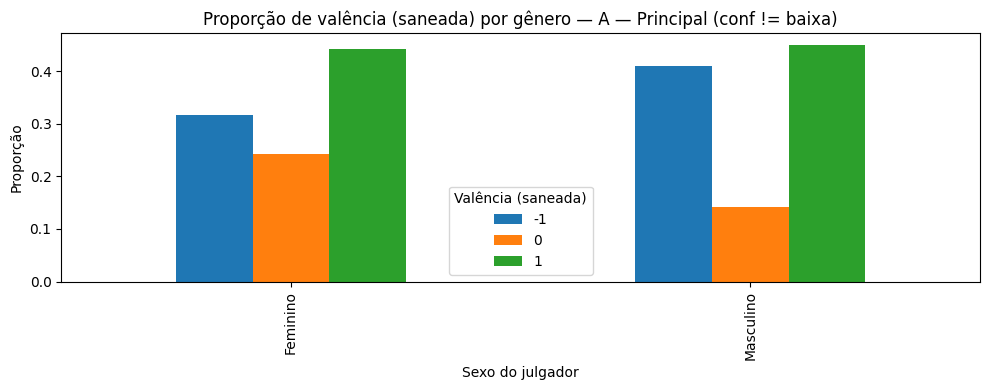

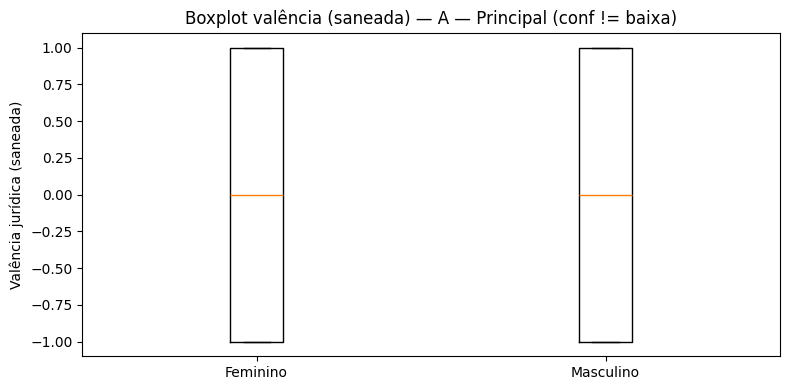


CENÁRIO: B — Conservador (conf == alta)
Base : /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal_saneado.parquet
Filtro: alta
Total Masculino: 144 | Total Feminino: 66 | Total: 210

=== Mann–Whitney U ===
U      = 4773.0000
p-valor = 0.955600

=== Qui-quadrado ===
Tabela de contingência (observado):
valencia_juridica_saneada  -1   0   1
sexo_julgador                        
Feminino                   25   7  34
Masculino                  53  17  74

χ²      = 0.0712
p-valor = 0.965050
DoF     = 2
Cramér’s V = 0.0184

--- Diagnóstico do Qui-quadrado (9A unificado) ---

Esperado:
valencia_juridica_saneada     -1      0      1
sexo_julgador                                 
Feminino                   24.51   7.54  33.94
Masculino                  53.49  16.46  74.06

Resíduos padronizados:
valencia_juridica_saneada    -1     0     1
sexo_julgador                              
Feminino                   0.10 -0.20  0.01
Masculino                 -0.07  0.

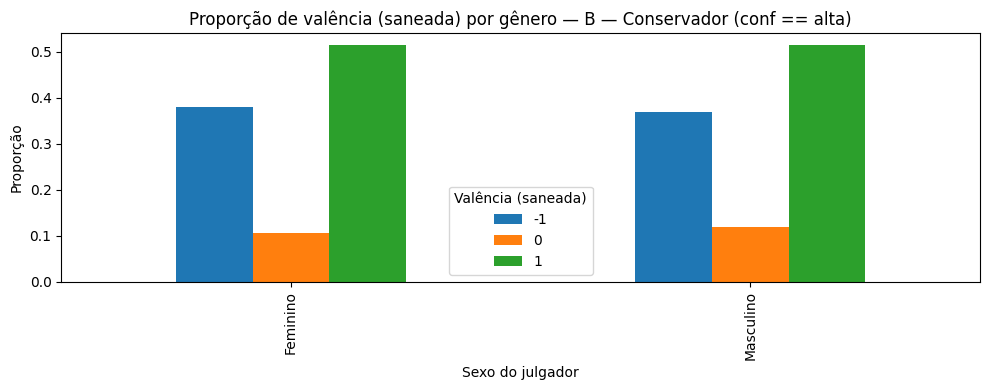

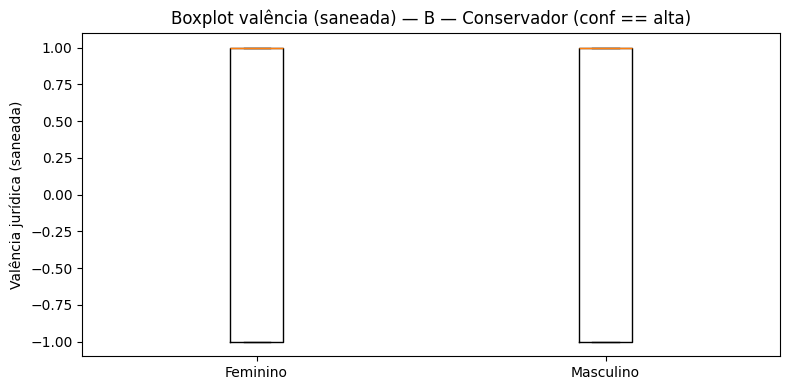


CENÁRIO: C — Robustez balanceado (conf != baixa)
Base : /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_robustez_saneado.parquet
Filtro: nao_baixa
Total Masculino: 102 | Total Feminino: 95 | Total: 197

=== Mann–Whitney U ===
U      = 4659.5000
p-valor = 0.614569

=== Qui-quadrado ===
Tabela de contingência (observado):
valencia_juridica_saneada  -1   0   1
sexo_julgador                        
Feminino                   30  23  42
Masculino                  44   9  49

χ²      = 9.0748
p-valor = 0.010701
DoF     = 2
Cramér’s V = 0.2146

--- Diagnóstico do Qui-quadrado (9A unificado) ---

Esperado:
valencia_juridica_saneada     -1      0      1
sexo_julgador                                 
Feminino                   35.69  15.43  43.88
Masculino                  38.31  16.57  47.12

Resíduos padronizados:
valencia_juridica_saneada    -1     0     1
sexo_julgador                              
Feminino                  -0.95  1.93 -0.28
Masculino             

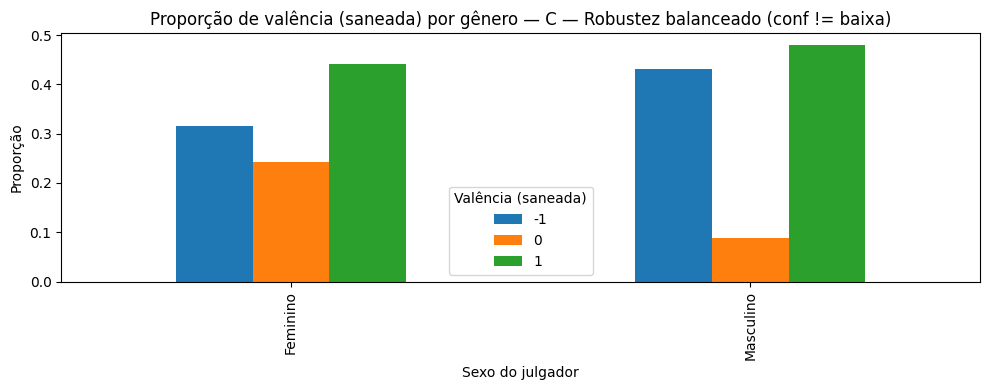

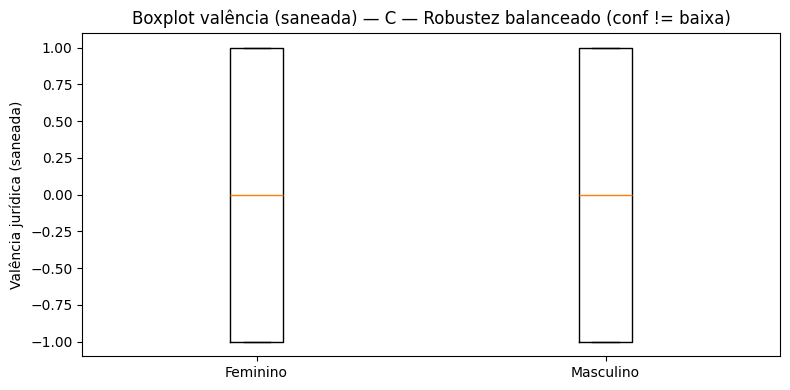


RESUMO FINAL (3 cenários)
                                   cenario  n_total  n_masc  n_fem    mw_u  \
0            A — Principal (conf != baixa)      315     220     95  9962.5   
1           B — Conservador (conf == alta)      210     144     66  4773.0   
2  C — Robustez balanceado (conf != baixa)      197     102     95  4659.5   

       mw_p      chi2    chi2_p  cramers_v  cliffs_d  
0  0.476451  5.488904  0.064284   0.132004 -0.046651  
1  0.955600  0.071151  0.965050   0.018407  0.004419  
2  0.614569  9.074837  0.010701   0.214628 -0.038287  


In [35]:
# ============================================================
# Bloco 7 — Estatística por 3 cenários (bases saneadas) unificado
# ============================================================

import os
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Funções auxiliares
# ------------------------------------------------------------

def cliffs_delta(a, b):
    """
    Cliff’s Delta para dois vetores.
    Retorna d em [-1, 1]. Implementação O(n*m) (ok para ~400 linhas).
    """
    a = np.asarray(a)
    b = np.asarray(b)

    greater = 0
    lower = 0
    for x in a:
        greater += np.sum(b < x)
        lower   += np.sum(b > x)

    d = (greater - lower) / (len(a) * len(b))
    return float(d)

def interpretar_cliffs(d):
    ad = abs(d)
    if ad < 0.147:
        return "efeito desprezível"
    elif ad < 0.330:
        return "efeito pequeno"
    elif ad < 0.474:
        return "efeito médio"
    else:
        return "efeito grande"

def cramers_v(chi2, n, r, c):
    """
    Cramér’s V para tabela RxC.
    """
    k = min(r - 1, c - 1)
    if k <= 0:
        return np.nan
    return float(np.sqrt(chi2 / (n * k)))

def padronizar_colunas_contingencia(cont, col_order=(-1, 0, 1)):
    """
    Garante que a tabela de contingência tenha as colunas -1,0,1 (se existirem no universo),
    preenchendo ausentes com 0 para consistência entre cenários.
    """
    cont = cont.copy()
    for c in col_order:
        if c not in cont.columns:
            cont[c] = 0
    cont = cont[list(col_order)]
    return cont

def calcular_residuos_qui2(cont):
    """
    Calcula esperado e resíduos padronizados (Pearson residuals):
      resid = (obs - exp) / sqrt(exp)
    Retorna: expected_df, resid_df
    """
    chi2, p, dof, expected = chi2_contingency(cont)
    expected_df = pd.DataFrame(expected, index=cont.index, columns=cont.columns)
    resid_df = (cont - expected_df) / np.sqrt(expected_df)
    return expected_df, resid_df, float(chi2), float(p), int(dof)

def destacar_maiores_residuos(resid_df, topk=2):
    """
    Retorna lista com as top-k células (linha, coluna, resid) por |resid|.
    """
    tmp = resid_df.copy()
    flat = []
    for r in tmp.index:
        for c in tmp.columns:
            flat.append((r, c, float(tmp.loc[r, c]), abs(float(tmp.loc[r, c]))))
    flat = sorted(flat, key=lambda x: x[3], reverse=True)
    return [(r, c, resid) for (r, c, resid, _) in flat[:topk]]

def preparar_df(path, filtro_conf):
    df = pd.read_parquet(path)

    required = ["sexo_julgador", "valencia_juridica_saneada", "conf_valencia"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Base {path} não tem colunas esperadas: {missing}")

    # manter apenas Masculino/Feminino
    df = df[df["sexo_julgador"].isin(["Masculino", "Feminino"])].copy()

    # aplicar filtro de confiança
    if filtro_conf == "nao_baixa":
        df = df[df["conf_valencia"] != "baixa"].copy()
    elif filtro_conf == "alta":
        df = df[df["conf_valencia"] == "alta"].copy()
    else:
        raise ValueError("filtro_conf inválido. Use 'nao_baixa' ou 'alta'.")

    # garantir numérico e apenas {-1,0,1}
    df["valencia_juridica_saneada"] = pd.to_numeric(df["valencia_juridica_saneada"], errors="coerce")
    df = df.dropna(subset=["valencia_juridica_saneada"]).copy()
    df = df[df["valencia_juridica_saneada"].isin([-1, 0, 1])].copy()

    # garantir tipo inteiro (opcional)
    df["valencia_juridica_saneada"] = df["valencia_juridica_saneada"].astype(int)

    return df

def rodar_cenario(nome, path, filtro_conf, plot=True, diagnostico_qui2=True, topk_residuos=2):
    print("\n" + "="*70)
    print(f"CENÁRIO: {nome}")
    print(f"Base : {path}")
    print(f"Filtro: {filtro_conf}")
    print("="*70)

    df = preparar_df(path, filtro_conf)

    vals_m = df[df["sexo_julgador"] == "Masculino"]["valencia_juridica_saneada"].values
    vals_f = df[df["sexo_julgador"] == "Feminino"]["valencia_juridica_saneada"].values

    print(f"Total Masculino: {len(vals_m)} | Total Feminino: {len(vals_f)} | Total: {len(df)}")

    # -----------------------------
    # 1) Mann–Whitney U
    # -----------------------------
    mw_stat, mw_p = mannwhitneyu(vals_m, vals_f, alternative="two-sided")
    print("\n=== Mann–Whitney U ===")
    print(f"U      = {mw_stat:.4f}")
    print(f"p-valor = {mw_p:.6f}")

    # -----------------------------
    # 2) Qui-quadrado + diagnóstico (9A embutido)
    # -----------------------------
    cont = pd.crosstab(df["sexo_julgador"], df["valencia_juridica_saneada"])
    cont = cont.reindex(index=["Feminino", "Masculino"]).fillna(0).astype(int)
    cont = padronizar_colunas_contingencia(cont, col_order=(-1, 0, 1))

    expected_df, resid_df, chi2_stat, chi2_p, dof = calcular_residuos_qui2(cont)

    print("\n=== Qui-quadrado ===")
    print("Tabela de contingência (observado):")
    print(cont)
    print(f"\nχ²      = {chi2_stat:.4f}")
    print(f"p-valor = {chi2_p:.6f}")
    print(f"DoF     = {dof}")

    # Cramér’s V
    n = cont.to_numpy().sum()
    r, c = cont.shape
    v = cramers_v(chi2_stat, n, r, c)
    print(f"Cramér’s V = {v:.4f}")

    if diagnostico_qui2:
        print("\n--- Diagnóstico do Qui-quadrado (9A unificado) ---")
        print("\nEsperado:")
        print(expected_df.round(2))
        print("\nResíduos padronizados:")
        print(resid_df.round(2))

        tops = destacar_maiores_residuos(resid_df, topk=topk_residuos)
        print("\nMaiores contribuições (maior |resíduo|):")
        for (linha, coluna, resid) in tops:
            sentido = "acima" if resid > 0 else "abaixo"
            print(f"- ({linha}, valência={coluna}): resid={resid:.2f} → observado {sentido} do esperado")

    # -----------------------------
    # 3) Cliff’s Delta
    # -----------------------------
    d = cliffs_delta(vals_m, vals_f)
    print("\n=== Cliff's Delta ===")
    print(f"d = {d:.4f} ({interpretar_cliffs(d)})")

    # -----------------------------
    # 4) Visualizações
    # -----------------------------
    if plot:
        # barras normalizadas por linha
        prop = pd.crosstab(
            df["sexo_julgador"],
            df["valencia_juridica_saneada"],
            normalize="index"
        )
        prop = prop.reindex(index=["Feminino", "Masculino"]).fillna(0)
        for col in [-1, 0, 1]:
            if col not in prop.columns:
                prop[col] = 0.0
        prop = prop[[-1, 0, 1]]

        prop.plot(kind="bar", figsize=(10,4))
        plt.title(f"Proporção de valência (saneada) por gênero — {nome}")
        plt.xlabel("Sexo do julgador")
        plt.ylabel("Proporção")
        plt.legend(title="Valência (saneada)")
        plt.tight_layout()
        plt.show()

        # boxplot (matplotlib puro) — usar tick_labels (matplotlib>=3.9)
        plt.figure(figsize=(8,4))
        plt.boxplot([vals_f, vals_m], tick_labels=["Feminino", "Masculino"])
        plt.title(f"Boxplot valência (saneada) — {nome}")
        plt.ylabel("Valência jurídica (saneada)")
        plt.tight_layout()
        plt.show()

    return {
        "cenario": nome,
        "n_total": int(len(df)),
        "n_masc": int(len(vals_m)),
        "n_fem": int(len(vals_f)),
        "mw_u": float(mw_stat),
        "mw_p": float(mw_p),
        "chi2": float(chi2_stat),
        "chi2_p": float(chi2_p),
        "cramers_v": float(v) if v == v else None,
        "cliffs_d": float(d),
    }

# ------------------------------------------------------------
# 2) Definição dos caminhos (bases saneadas do Bloco 6B)
# ------------------------------------------------------------
base_dir = "/content/drive/MyDrive/Processos_Jurídicos/datasets"

PATH_PRINCIPAL = os.path.join(base_dir, "tjdf_decisoes_analise_principal_saneado.parquet")
PATH_ROBUSTEZ  = os.path.join(base_dir, "tjdf_decisoes_analise_robustez_saneado.parquet")

# ------------------------------------------------------------
# 3) Executar 3 cenários
# ------------------------------------------------------------
resultados = []

resultados.append(rodar_cenario(
    nome="A — Principal (conf != baixa)",
    path=PATH_PRINCIPAL,
    filtro_conf="nao_baixa",
    plot=True,
    diagnostico_qui2=True,
    topk_residuos=2
))

resultados.append(rodar_cenario(
    nome="B — Conservador (conf == alta)",
    path=PATH_PRINCIPAL,
    filtro_conf="alta",
    plot=True,
    diagnostico_qui2=True,
    topk_residuos=2
))

resultados.append(rodar_cenario(
    nome="C — Robustez balanceado (conf != baixa)",
    path=PATH_ROBUSTEZ,
    filtro_conf="nao_baixa",
    plot=True,
    diagnostico_qui2=True,
    topk_residuos=2
))

print("\n" + "="*70)
print("RESUMO FINAL (3 cenários)")
print("="*70)
print(pd.DataFrame(resultados))


### Bloco 8 — Relação entre Complexidade Textual e Valência Jurídica (bases saneadas)

Objetivo:
Entender como métricas de **complexidade textual** se relacionam com a **valência jurídica** estimada pelo pipeline, utilizando exclusivamente as **bases saneadas do Bloco 6B**.

A análise será executada nos mesmos **3 cenários** do Bloco 7 (estatística), garantindo comparabilidade direta:

---

## Cenários

### Cenário A — Principal (conf != baixa)
- Base: `tjdf_decisoes_analise_principal_saneado.parquet`
- Filtro: `conf_valencia != "baixa"`
- Interpretação: fotografia mais realista (não balanceada)

### Cenário B — Conservador (conf == alta)
- Base: `tjdf_decisoes_analise_principal_saneado.parquet`
- Filtro: `conf_valencia == "alta"`
- Interpretação: ruído mínimo (maior confiabilidade)

### Cenário C — Robustez balanceado (conf != baixa)
- Base: `tjdf_decisoes_analise_robustez_saneado.parquet`
- Filtro: `conf_valencia != "baixa"`
- Interpretação: controle de distribuição por gênero

---

## Variáveis

### Valência (saneada)
- `valencia_juridica_saneada` ∈ {-1, 0, 1}

### Score contínuo (para correlação)
- `score_valencia` (contínuo, com sinal)

### Complexidade textual (fundamentação)
- `n_palavras`
- `ttr`
- `flesch_score`
- `tam_medio_palavra`

---

## Saídas do bloco

Para cada cenário, o bloco produz:

1. Estatísticas descritivas de complexidade por `valencia_juridica_saneada` (geral)
2. Estatísticas descritivas por (sexo × valência)
3. Correlações Spearman:
   - complexidade × `valencia_juridica_saneada`
   - complexidade × `score_valencia` (proxy contínuo)
4. Diagnóstico focal em **valência 0 (neutra/processual)**:
   - comparação de complexidade em valência=0 por gênero
   (motivação: no Bloco 7, os resíduos do Qui-quadrado indicaram que o maior desvio entre gêneros ocorre no nível neutro)

O bloco é exploratório e prepara a base argumentativa para a modelagem com interação (complexidade × gênero) nas próximas etapas.


In [40]:
# ============================================================
# Bloco 8 — Complexidade x Valência (bases saneadas, 3 cenários)
# (VERSÃO FINAL — com correção do “bug lógico” do foco em valência 0)
# ============================================================

import os
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# ------------------------------------------------------------
# 1) Configurações
# ------------------------------------------------------------
base_dir = "/content/drive/MyDrive/Processos_Jurídicos/datasets"

PATH_PRINCIPAL = os.path.join(base_dir, "tjdf_decisoes_analise_principal_saneado.parquet")
PATH_ROBUSTEZ  = os.path.join(base_dir, "tjdf_decisoes_analise_robustez_saneado.parquet")

COLS_COMPLEX = ["n_palavras", "ttr", "flesch_score", "tam_medio_palavra"]

# ------------------------------------------------------------
# 2) Funções auxiliares
# ------------------------------------------------------------
def preparar_df_complex(path, filtro_conf):
    df = pd.read_parquet(path)

    required = ["sexo_julgador", "valencia_juridica_saneada", "conf_valencia", "score_valencia"] + COLS_COMPLEX
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Base {path} não tem colunas esperadas: {missing}")

    # manter apenas Masculino/Feminino
    df = df[df["sexo_julgador"].isin(["Masculino", "Feminino"])].copy()

    # filtro confiança
    if filtro_conf == "nao_baixa":
        df = df[df["conf_valencia"] != "baixa"].copy()
    elif filtro_conf == "alta":
        df = df[df["conf_valencia"] == "alta"].copy()
    else:
        raise ValueError("filtro_conf inválido. Use 'nao_baixa' ou 'alta'.")

    # garantir numérico
    df["valencia_juridica_saneada"] = pd.to_numeric(df["valencia_juridica_saneada"], errors="coerce")
    df["score_valencia"] = pd.to_numeric(df["score_valencia"], errors="coerce")

    # remover linhas inválidas
    df = df.dropna(subset=["valencia_juridica_saneada", "score_valencia"])

    return df


def spearman_report(df, ycol, label):
    print(f"\n=== Correlações Spearman ({label}) usando {ycol} ===")

    # se a variável alvo não varia, Spearman não faz sentido
    if df[ycol].nunique(dropna=True) < 2:
        print(f"{ycol} sem variação neste recorte (nunique < 2) → Spearman não aplicável.")
        return

    corr = df[[ycol] + COLS_COMPLEX].corr(method="spearman")[ycol]
    print(corr)


def resumo_complexidade(df, group_cols, title):
    print(f"\n=== {title} ===")
    agg = (
        df.groupby(group_cols)[COLS_COMPLEX]
          .agg(["mean", "std", "median", "count"])
    )
    print(agg)


def teste_mw_metric(sub, col):
    """
    Mann–Whitney U para comparar a métrica de complexidade entre gêneros dentro de um recorte.
    Retorna (U, p, nM, nF) ou None se amostra pequena.
    """
    f = sub[sub["sexo_julgador"] == "Feminino"][col].dropna().values
    m = sub[sub["sexo_julgador"] == "Masculino"][col].dropna().values
    if len(f) < 5 or len(m) < 5:
        return None
    u, p = mannwhitneyu(m, f, alternative="two-sided")
    return float(u), float(p), len(m), len(f)


def foco_valencia_neutra(df, title):
    """
    Diagnóstico focal: valência 0 (neutra/processual),
    pois (quando aplicável) foi onde os resíduos do Qui² mostraram maior desvio entre gêneros.

    IMPORTANTE:
    - No recorte valência=0, score_valencia tende a ser constante por construção do rótulo,
      logo correlações (Spearman/Pearson) não são aplicáveis.
    """
    sub = df[df["valencia_juridica_saneada"] == 0].copy()
    print(f"\n--- Foco em valência 0 (neutra) — {title} ---")
    print(f"Linhas com valência=0: {len(sub)}")
    if len(sub) == 0:
        print("Sem casos neutros neste recorte.")
        return

    # descritivas por gênero somente para valência 0
    resumo_complexidade(sub, ["sexo_julgador"], "Complexidade (apenas valência=0) por gênero")

    # testes MW por métrica dentro do neutro
    print("\nTeste Mann–Whitney (apenas valência=0) — por métrica:")
    for col in COLS_COMPLEX:
        res = teste_mw_metric(sub, col)
        if res is None:
            print(f"- {col}: amostra pequena → não testado")
        else:
            u, p, nm, nf = res
            print(f"- {col}: U={u:.2f} | p={p:.6f} | nM={nm} | nF={nf}")

    # correlação com score contínuo dentro do neutro (geralmente não aplicável)
    print("\nObs.: no recorte de valência neutra (0), a variável score_valencia é constante por construção do rótulo. "
          "Portanto, correlações (Spearman/Pearson) não são estatisticamente aplicáveis.")


def rodar_cenario_complex(nome, path, filtro_conf, chi2_p=None, max_abs_resid=None):
    """
    Executa as análises de complexidade textual x valência em um cenário.

    Correção do “bug lógico”:
    - O foco em valência 0 só é aplicado quando há evidência forte de desvio (Qui² significativo
      ou resíduos elevados) — pois isso ocorre, tipicamente, apenas no cenário onde o Qui²
      indicou associação relevante.
    """
    print("\n" + "="*70)
    print(f"CENÁRIO: {nome}")
    print(f"Base : {path}")
    print(f"Filtro: {filtro_conf}")
    print("="*70)

    df = preparar_df_complex(path, filtro_conf)

    print(f"Linhas: {len(df)}")
    print("Distribuição por sexo:")
    print(df["sexo_julgador"].value_counts())

    print("\nDistribuição por valência (saneada):")
    print(df["valencia_juridica_saneada"].value_counts().sort_index())

    # 1) Descritivas por valência (geral)
    resumo_complexidade(df, ["valencia_juridica_saneada"], "Complexidade por valência (GERAL)")

    # 2) Descritivas por sexo x valência
    resumo_complexidade(df, ["sexo_julgador", "valencia_juridica_saneada"], "Complexidade por sexo x valência")

    # 3) Spearman: ordinal
    spearman_report(df, "valencia_juridica_saneada", f"{nome} — GERAL (ordinal)")

    # 4) Spearman: contínuo
    spearman_report(df, "score_valencia", f"{nome} — GERAL (contínuo)")

    # 5) Spearman por gênero
    spearman_report(df[df["sexo_julgador"] == "Masculino"], "score_valencia", f"{nome} — Masculino (contínuo)")
    spearman_report(df[df["sexo_julgador"] == "Feminino"],  "score_valencia", f"{nome} — Feminino (contínuo)")

    # 6) Diagnóstico focal: valência neutra (SÓ quando fizer sentido)
    gatilho_chi2 = (chi2_p is not None and chi2_p < 0.05)
    gatilho_resid = (max_abs_resid is not None and max_abs_resid >= 1.5)

    if gatilho_chi2 or gatilho_resid:
        foco_valencia_neutra(df, nome)
    else:
        print(f"\n--- Foco em valência 0 (neutra) — {nome} ---")
        print("Diagnóstico focal não aplicado: cenário sem evidência forte (Qui² não significativo e resíduos baixos).")

    return df


# ------------------------------------------------------------
# 3) Executar 3 cenários (mesma lógica do Bloco 7)
#    (preencha chi2_p e max_abs_resid com os valores do Bloco 7/9A)
# ------------------------------------------------------------

# Valores conforme seus outputs:
# A: chi2_p=0.064284 | max_abs_resid=1.66
# B: chi2_p=0.965050 | max_abs_resid=0.20
# C: chi2_p=0.010701 | max_abs_resid=1.93

dfA = rodar_cenario_complex(
    nome="A — Principal (conf != baixa)",
    path=PATH_PRINCIPAL,
    filtro_conf="nao_baixa",
    chi2_p=0.064284,
    max_abs_resid=1.66
)

dfB = rodar_cenario_complex(
    nome="B — Conservador (conf == alta)",
    path=PATH_PRINCIPAL,
    filtro_conf="alta",
    chi2_p=0.965050,
    max_abs_resid=0.20
)

dfC = rodar_cenario_complex(
    nome="C — Robustez balanceado (conf != baixa)",
    path=PATH_ROBUSTEZ,
    filtro_conf="nao_baixa",
    chi2_p=0.010701,
    max_abs_resid=1.93
)



CENÁRIO: A — Principal (conf != baixa)
Base : /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal_saneado.parquet
Filtro: nao_baixa
Linhas: 315
Distribuição por sexo:
sexo_julgador
Masculino    220
Feminino      95
Name: count, dtype: int64

Distribuição por valência (saneada):
valencia_juridica_saneada
-1    120
 0     54
 1    141
Name: count, dtype: int64

=== Complexidade por valência (GERAL) ===
                            n_palavras                                  ttr  \
                                  mean          std  median count      mean   
valencia_juridica_saneada                                                     
-1                         1765.033333  1130.054940  1539.5   120  0.393446   
 0                         1479.962963   755.424883  1453.0    54  0.399561   
 1                         1864.695035  1026.340900  1686.0   141  0.361302   

                                                    flesch_score            \
         

### Bloco Final — Visualizações dos Resultados (Leitura Rápida e Comunicação Científica)

**Objetivo.** Este bloco apresenta visualizações **estritamente descritivas e ilustrativas** para facilitar a leitura dos resultados estatísticos obtidos nos blocos anteriores.  
Os gráficos **não introduzem novas hipóteses**, **não substituem** os testes inferenciais e **não são utilizados para “buscar significância”**; servem para tornar mais intuitivas:

1. A **distribuição de valência jurídica** por gênero (proporções por classe).  
2. A **dispersão e sobreposição** das métricas de complexidade textual por gênero, com **foco na valência neutra (0)** — ponto de maior interesse diagnóstico observado nos resíduos do Qui-quadrado.  
3. A visualização de que as associações entre **score contínuo de valência** e complexidade são **fracas**, alinhadas às correlações de Spearman previamente reportadas.

**Interpretação esperada (guia).**
- Se as barras por gênero forem semelhantes em cada classe de valência, isso corrobora **ausência de diferença global forte**.
- Se os boxplots por gênero se sobrepuserem amplamente (mesmo quando houver p-valor baixo em algum recorte), isso sugere **efeitos pequenos / baixa separabilidade prática**.
- Se os dispersogramas não apresentarem separação clara entre gêneros, reforça-se a conclusão de **associações fracas** entre complexidade e valência.

**Escopo.** O bloco reutiliza as **bases saneadas** e os **3 cenários** (A, B, C) já adotados no Bloco 8, preservando a mesma lógica de filtragem por confiança (`conf_valencia`).



CENÁRIO (GRÁFICOS): A — Principal (conf != baixa)
Base : /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal_saneado.parquet
Filtro: nao_baixa


/tmp/ipython-input-4230619320.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["sexo_julgador", "valencia_juridica_saneada"])
/tmp/ipython-input-4230619320.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tot = tab.groupby("sexo_julgador")["n"].transform("sum")


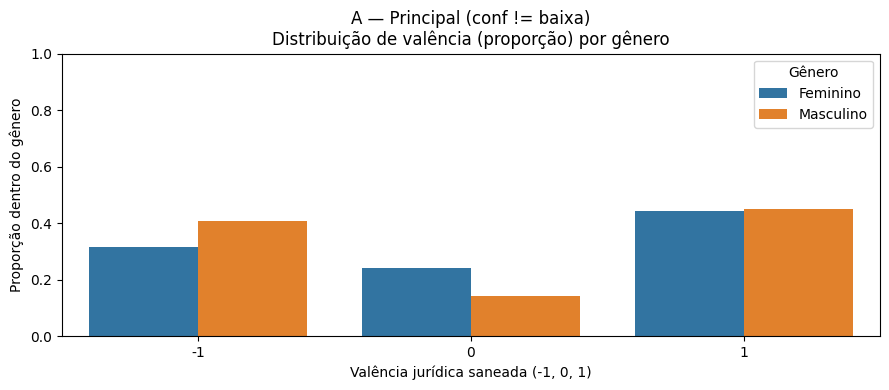


[A — Principal (conf != baixa)] Linhas com valência neutra (0): 54


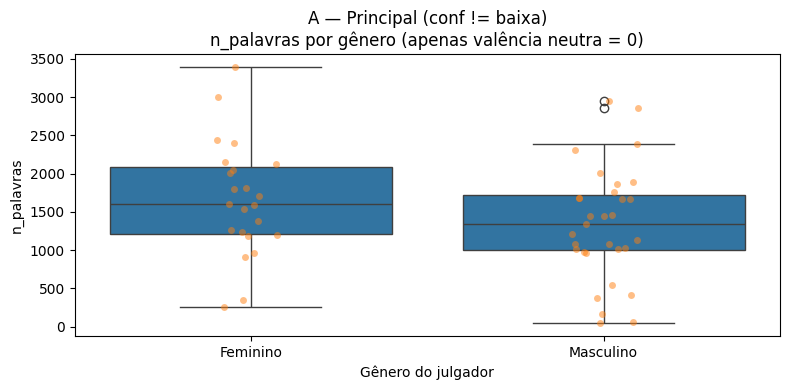

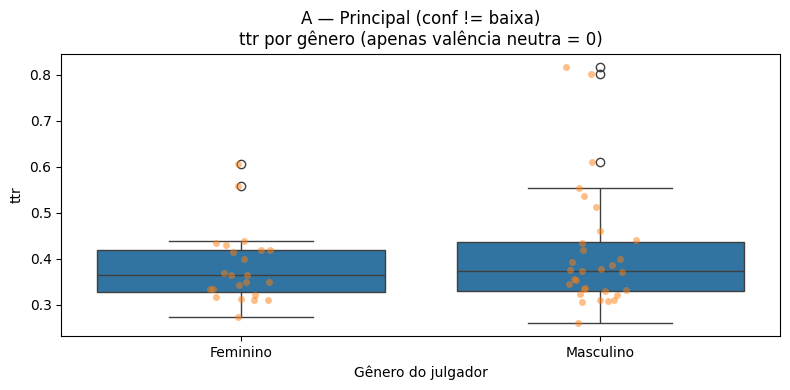

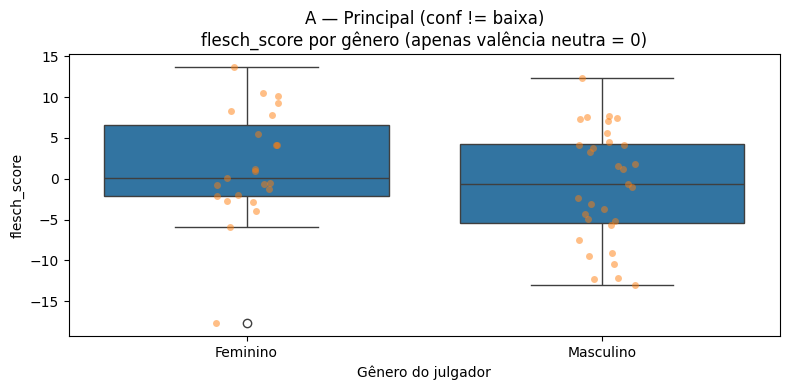

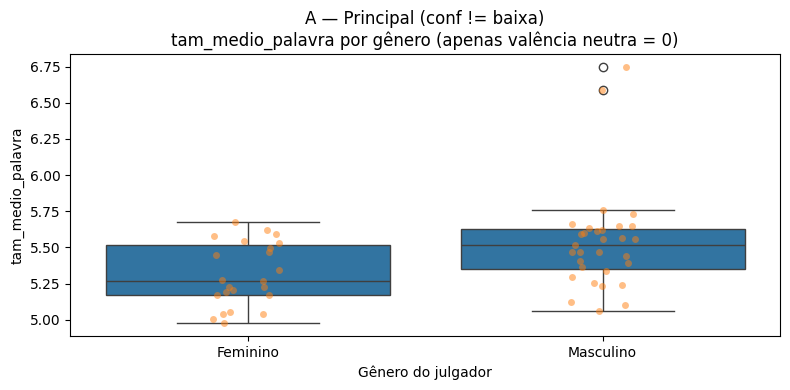

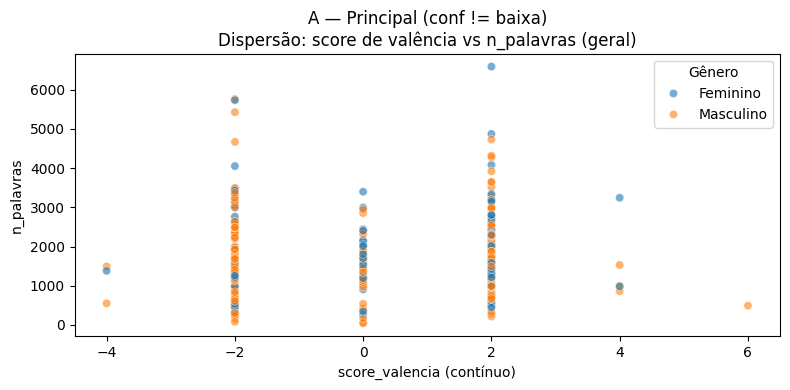


CENÁRIO (GRÁFICOS): B — Conservador (conf == alta)
Base : /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_principal_saneado.parquet
Filtro: alta


/tmp/ipython-input-4230619320.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["sexo_julgador", "valencia_juridica_saneada"])
/tmp/ipython-input-4230619320.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tot = tab.groupby("sexo_julgador")["n"].transform("sum")


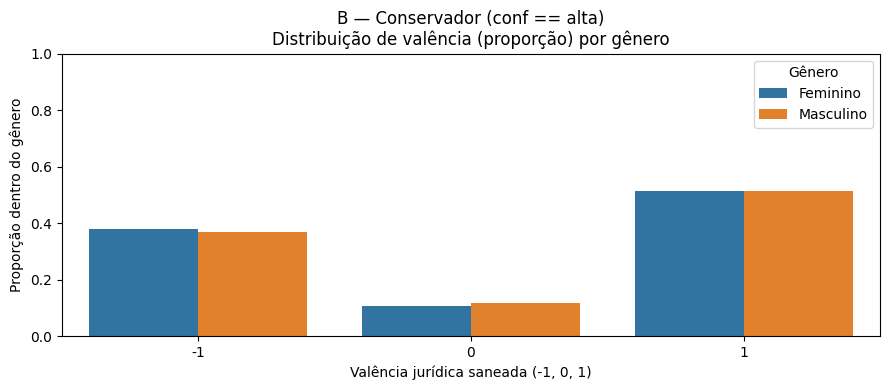


[B — Conservador (conf == alta)] Linhas com valência neutra (0): 24


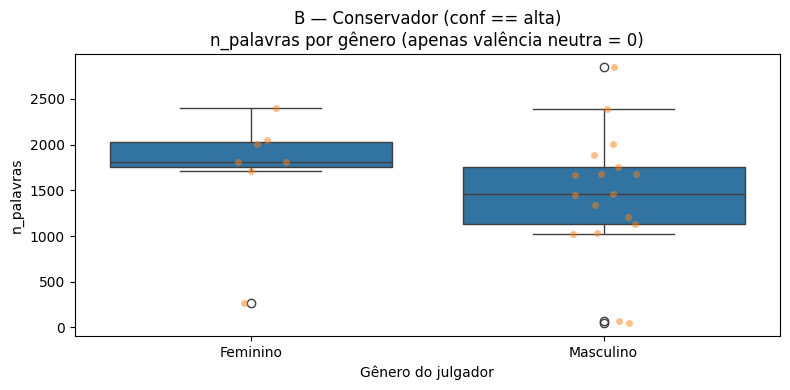

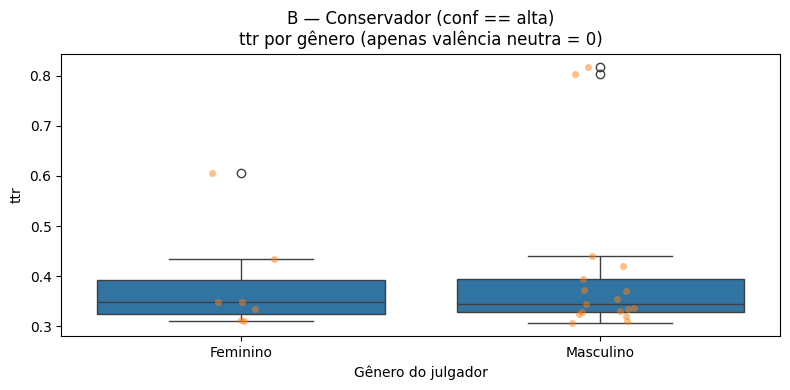

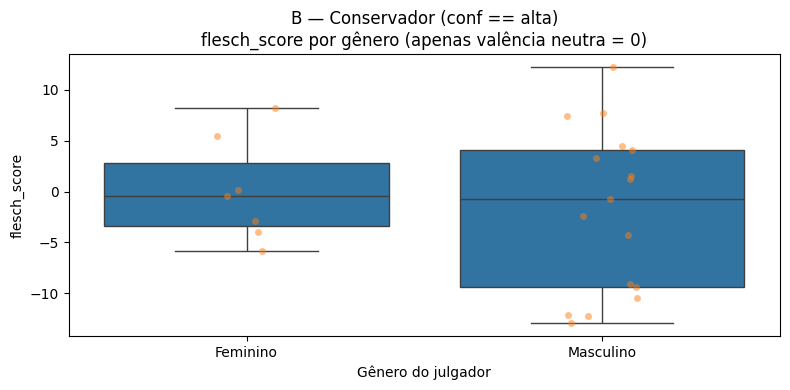

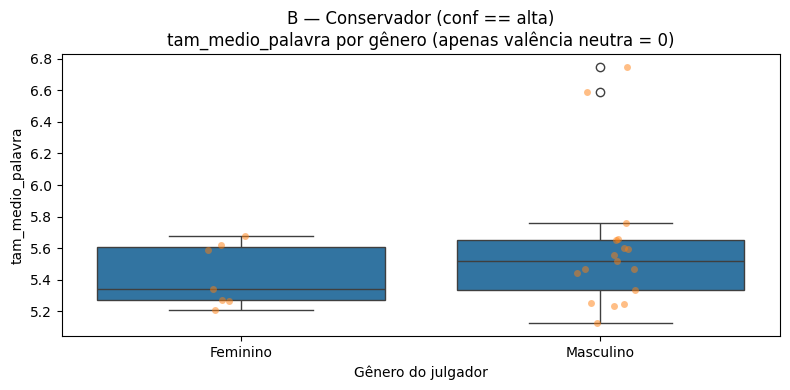

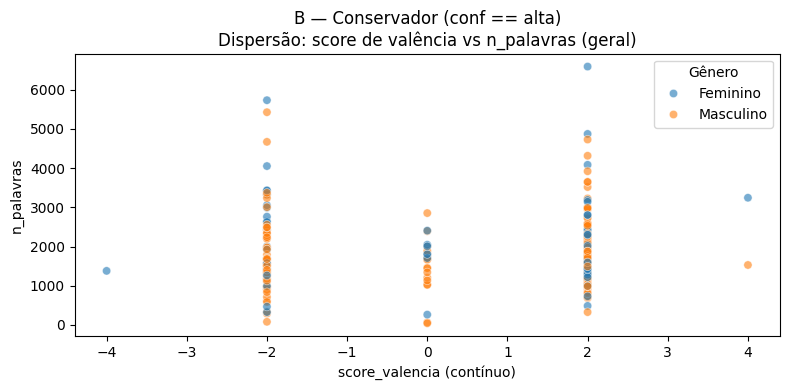


CENÁRIO (GRÁFICOS): C — Robustez balanceado (conf != baixa)
Base : /content/drive/MyDrive/Processos_Jurídicos/datasets/tjdf_decisoes_analise_robustez_saneado.parquet
Filtro: nao_baixa


/tmp/ipython-input-4230619320.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["sexo_julgador", "valencia_juridica_saneada"])
/tmp/ipython-input-4230619320.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tot = tab.groupby("sexo_julgador")["n"].transform("sum")


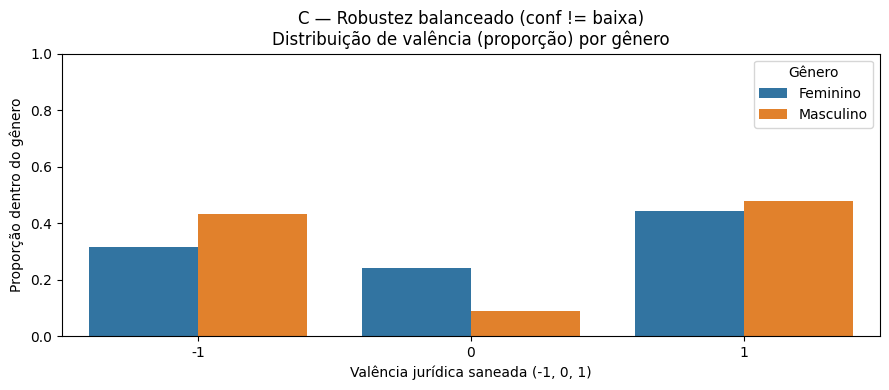


[C — Robustez balanceado (conf != baixa)] Linhas com valência neutra (0): 32


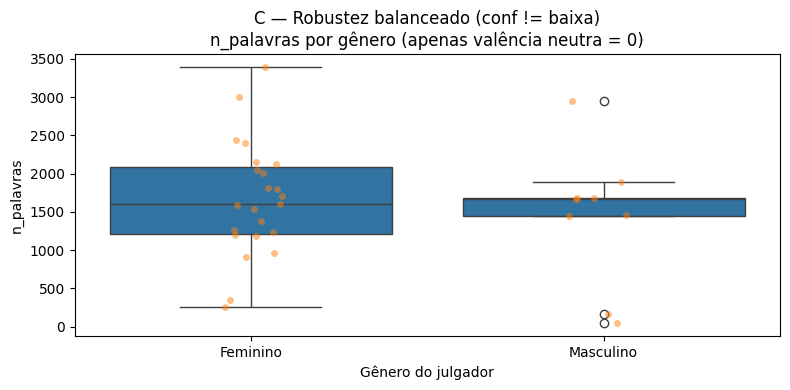

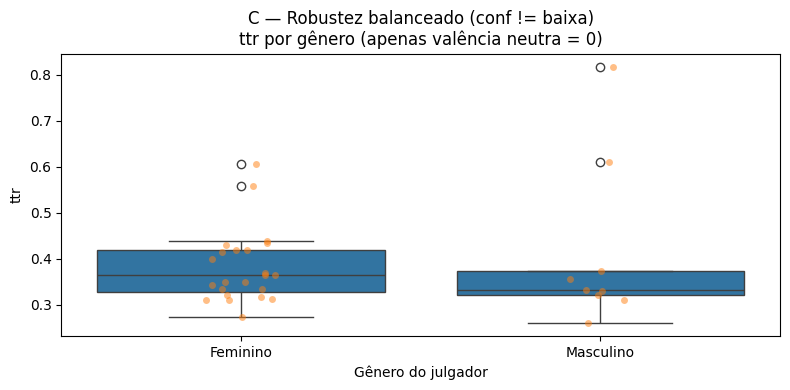

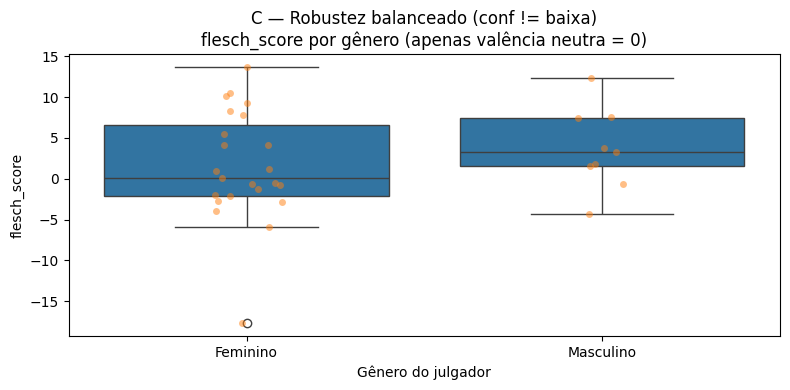

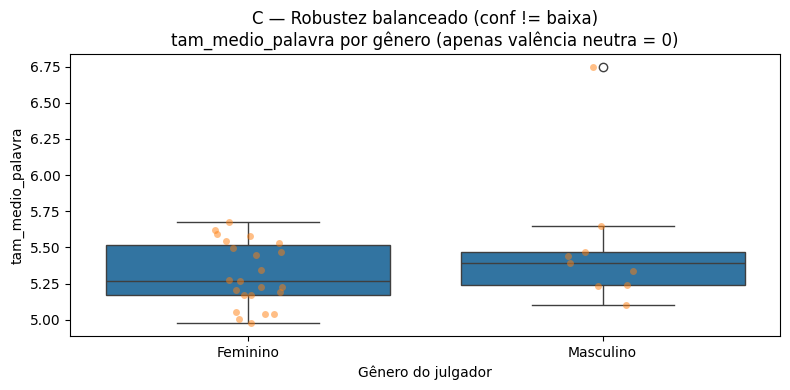

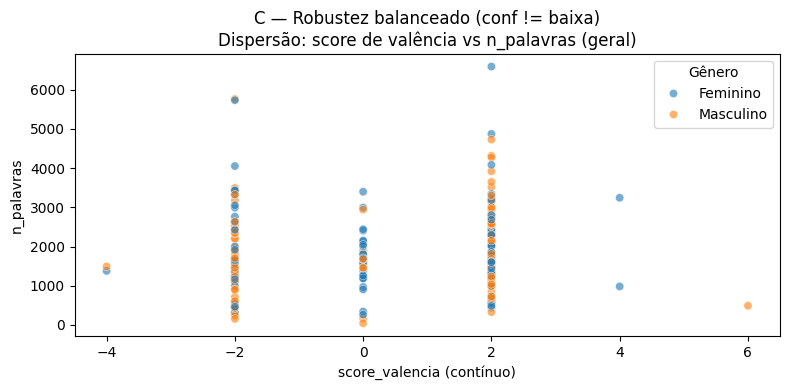

In [41]:
# ============================================================
# Bloco Final — Visualizações (3 cenários, bases saneadas)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (Opcional) Seaborn facilita boxplot/stripplot.
# Se não tiver seaborn, o bloco ainda roda com matplotlib puro.
try:
    import seaborn as sns
    HAS_SNS = True
except ImportError:
    HAS_SNS = False

# ------------------------------------------------------------
# 1) Configurações (reaproveitando padrão do Bloco 8)
# ------------------------------------------------------------
base_dir = "/content/drive/MyDrive/Processos_Jurídicos/datasets"

PATH_PRINCIPAL = os.path.join(base_dir, "tjdf_decisoes_analise_principal_saneado.parquet")
PATH_ROBUSTEZ  = os.path.join(base_dir, "tjdf_decisoes_analise_robustez_saneado.parquet")

COLS_COMPLEX = ["n_palavras", "ttr", "flesch_score", "tam_medio_palavra"]

# Ordem desejada das classes (garante consistência visual)
ORDER_VAL = [-1, 0, 1]
ORDER_SEX = ["Feminino", "Masculino"]

# ------------------------------------------------------------
# 2) Funções auxiliares
# ------------------------------------------------------------
def preparar_df_plot(path, filtro_conf):
    df = pd.read_parquet(path)

    required = ["sexo_julgador", "valencia_juridica_saneada", "conf_valencia", "score_valencia"] + COLS_COMPLEX
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Base {path} não tem colunas esperadas: {missing}")

    # manter apenas Masculino/Feminino
    df = df[df["sexo_julgador"].isin(ORDER_SEX)].copy()

    # filtro confiança
    if filtro_conf == "nao_baixa":
        df = df[df["conf_valencia"] != "baixa"].copy()
    elif filtro_conf == "alta":
        df = df[df["conf_valencia"] == "alta"].copy()
    else:
        raise ValueError("filtro_conf inválido. Use 'nao_baixa' ou 'alta'.")

    # garantir numérico e classes válidas
    df["valencia_juridica_saneada"] = pd.to_numeric(df["valencia_juridica_saneada"], errors="coerce")
    df["score_valencia"] = pd.to_numeric(df["score_valencia"], errors="coerce")

    df = df.dropna(subset=["valencia_juridica_saneada", "score_valencia"])
    df = df[df["valencia_juridica_saneada"].isin(ORDER_VAL)].copy()

    # categorias para ordenação estável
    df["sexo_julgador"] = pd.Categorical(df["sexo_julgador"], categories=ORDER_SEX, ordered=True)
    df["valencia_juridica_saneada"] = pd.Categorical(df["valencia_juridica_saneada"], categories=ORDER_VAL, ordered=True)

    return df


def plot_valencia_por_genero(df, titulo):
    """
    Gráfico 1: proporção de classes de valência por gênero (barras lado a lado).
    """
    tab = (
        df.groupby(["sexo_julgador", "valencia_juridica_saneada"])
          .size()
          .rename("n")
          .reset_index()
    )

    # total por gênero para virar proporção
    tot = tab.groupby("sexo_julgador")["n"].transform("sum")
    tab["prop"] = tab["n"] / tot

    plt.figure(figsize=(9, 4))

    if HAS_SNS:
        sns.barplot(
            data=tab,
            x="valencia_juridica_saneada",
            y="prop",
            hue="sexo_julgador",
            errorbar=None
        )
    else:
        # fallback matplotlib puro
        x = np.arange(len(ORDER_VAL))
        width = 0.4
        for i, sx in enumerate(ORDER_SEX):
            sub = tab[tab["sexo_julgador"] == sx].set_index("valencia_juridica_saneada").reindex(ORDER_VAL)
            plt.bar(x + (i - 0.5) * width, sub["prop"].values, width=width, label=sx)

        plt.xticks(x, ORDER_VAL)

    plt.title(f"{titulo}\nDistribuição de valência (proporção) por gênero")
    plt.xlabel("Valência jurídica saneada (-1, 0, 1)")
    plt.ylabel("Proporção dentro do gênero")
    plt.ylim(0, 1)
    plt.legend(title="Gênero", loc="best")
    plt.tight_layout()
    plt.show()


def plot_boxplots_neutra(df, titulo):
    """
    Gráfico 2: boxplots por gênero apenas para valência neutra (0).
    """
    sub = df[df["valencia_juridica_saneada"] == 0].copy()
    print(f"\n[{titulo}] Linhas com valência neutra (0): {len(sub)}")

    if len(sub) == 0:
        print("Sem casos neutros neste recorte. Boxplots não serão gerados.")
        return

    for col in COLS_COMPLEX:
        plt.figure(figsize=(8, 4))

        if HAS_SNS:
            sns.boxplot(data=sub, x="sexo_julgador", y=col, order=ORDER_SEX)
            # pontos para mostrar sobreposição (amostra pequena pode ser útil)
            sns.stripplot(data=sub, x="sexo_julgador", y=col, order=ORDER_SEX, dodge=False, alpha=0.5)
        else:
            # fallback matplotlib
            vals = [sub[sub["sexo_julgador"] == sx][col].dropna().values for sx in ORDER_SEX]
            plt.boxplot(vals, labels=ORDER_SEX)

        plt.title(f"{titulo}\n{col} por gênero (apenas valência neutra = 0)")
        plt.xlabel("Gênero do julgador")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()


def plot_scatter_score_vs_complex(df, titulo, ycol="n_palavras"):
    """
    Gráfico 3: dispersão de score contínuo vs uma métrica de complexidade (geral).
    """
    plt.figure(figsize=(8, 4))

    if HAS_SNS:
        sns.scatterplot(data=df, x="score_valencia", y=ycol, hue="sexo_julgador", alpha=0.6)
        # tendência (LOWESS) pode ser útil, mas deixa opcional por padrão.
        # sns.regplot(data=df, x="score_valencia", y=ycol, scatter=False, lowess=True)
    else:
        for sx in ORDER_SEX:
            sub = df[df["sexo_julgador"] == sx]
            plt.scatter(sub["score_valencia"], sub[ycol], alpha=0.6, label=sx)

    plt.title(f"{titulo}\nDispersão: score de valência vs {ycol} (geral)")
    plt.xlabel("score_valencia (contínuo)")
    plt.ylabel(ycol)
    plt.legend(title="Gênero", loc="best")
    plt.tight_layout()
    plt.show()


def rodar_graficos_cenario(nome, path, filtro_conf):
    print("\n" + "="*70)
    print(f"CENÁRIO (GRÁFICOS): {nome}")
    print(f"Base : {path}")
    print(f"Filtro: {filtro_conf}")
    print("="*70)

    df = preparar_df_plot(path, filtro_conf)

    # 1) Distribuição da valência por gênero
    plot_valencia_por_genero(df, nome)

    # 2) Boxplots de complexidade focando valência neutra
    plot_boxplots_neutra(df, nome)

    # 3) Dispersão score vs uma métrica (n_palavras por padrão)
    plot_scatter_score_vs_complex(df, nome, ycol="n_palavras")

    return df


# ------------------------------------------------------------
# 3) Executar gráficos nos 3 cenários
# ------------------------------------------------------------
_ = rodar_graficos_cenario(
    nome="A — Principal (conf != baixa)",
    path=PATH_PRINCIPAL,
    filtro_conf="nao_baixa"
)

_ = rodar_graficos_cenario(
    nome="B — Conservador (conf == alta)",
    path=PATH_PRINCIPAL,
    filtro_conf="alta"
)

_ = rodar_graficos_cenario(
    nome="C — Robustez balanceado (conf != baixa)",
    path=PATH_ROBUSTEZ,
    filtro_conf="nao_baixa"
)


## Considerações Finais e Síntese dos Achados

Este estudo investigou a existência de diferenças sistemáticas de sentimento (valência jurídica) em decisões judiciais proferidas por juízes e juízas no Brasil, a partir de um corpus de sentenças do Tribunal de Justiça do Distrito Federal e Territórios (TJDFT), empregando técnicas de Processamento de Linguagem Natural (PLN) e análise estatística robusta.

### Síntese do fluxo metodológico

O pipeline analítico desenvolvido contemplou:

1. **Coleta e preparação dos dados**
   - Construção de um corpus de decisões judiciais públicas.
   - Limpeza textual e padronização das sentenças.
   - Extração automatizada de métricas linguísticas e de sentimento.

2. **Inferência e saneamento**
   - Identificação do gênero do julgador.
   - Classificação da valência jurídica em categorias negativa (-1), neutra (0) e positiva (1).
   - Saneamento metodológico (Bloco 6B), com controle de confiabilidade do rótulo (`conf_valencia`) e criação de bases alternativas para análise de robustez.

3. **Análises estatísticas principais**
   - Testes não paramétricos (Mann–Whitney U) para comparação de distribuições.
   - Testes de independência (Qui-quadrado) acompanhados de medidas de efeito (Cramér’s V).
   - Cálculo de Cliff’s Delta para avaliação do tamanho de efeito.
   - Diagnóstico aprofundado via resíduos padronizados do Qui-quadrado.
   - Avaliação em três cenários complementares:
     - **Cenário A (Principal)**: base saneada com exclusão de rótulos de baixa confiança.
     - **Cenário B (Conservador)**: restrição a rótulos de alta confiança.
     - **Cenário C (Robustez)**: base balanceada por gênero.

4. **Análise de complexidade textual**
   - Métricas objetivas (número de palavras, TTR, índice de Flesch e tamanho médio de palavra).
   - Correlações de Spearman com a valência ordinal e com o score contínuo de sentimento.
   - Análises estratificadas por gênero e por cenários.
   - Diagnóstico focal na valência neutra (0), identificada como a categoria com maior contribuição para desvios no teste Qui-quadrado.

---

### Principais achados empíricos

Os resultados obtidos convergem de forma consistente nos três cenários analisados:

1. **Ausência de diferenças robustas de sentimento por gênero**
   - Os testes de Mann–Whitney não indicaram diferenças estatisticamente significativas entre as distribuições de valência jurídica atribuídas a decisões de juízes e juízas.
   - As medidas de tamanho de efeito (Cliff’s Delta) foram sistematicamente classificadas como **desprezíveis**.

2. **Evidências pontuais no teste Qui-quadrado**
   - No cenário de robustez (balanceado), observou-se significância estatística no teste Qui-quadrado.
   - A análise dos resíduos padronizados revelou que essa significância está concentrada principalmente na **valência neutra (0)**, com decisões neutras relativamente mais frequentes entre juízas e menos frequentes entre juízes.
   - Ainda assim, o tamanho de efeito (Cramér’s V) permaneceu em patamar **baixo a moderado**, indicando que o impacto prático é limitado.

3. **Complexidade textual e sentimento**
   - As correlações entre métricas de complexidade textual e valência jurídica foram fracas em todos os cenários.
   - Não se observou relação monotônica forte entre extensão, legibilidade ou diversidade lexical e a polaridade do julgamento.
   - As análises estratificadas por gênero não indicaram padrões sistematicamente distintos.

4. **Diagnóstico focal da valência neutra**
   - No cenário principal, identificou-se diferença estatisticamente significativa entre gêneros apenas para o **tamanho médio da palavra** em decisões neutras.
   - Tal achado é pontual, não replicado de forma consistente nos cenários conservador e de robustez, sugerindo cautela interpretativa.

---

### Interpretação e implicações

Do ponto de vista metodológico e substantivo, os resultados indicam que:

- **Não há evidência robusta de que juízes e juízas diferem sistematicamente no tom decisório**, quando medido por valência jurídica extraída automaticamente por modelos de PLN.
- Diferenças pontuais observadas concentram-se em decisões de natureza processual/neutra e apresentam **baixo tamanho de efeito**, o que limita sua relevância prática.
- A ausência de diferenças significativas não deve ser interpretada como limitação do estudo, mas como um resultado informativo, coerente com uma abordagem científica rigorosa e transparente.

---

### Limitações e trabalhos futuros

Entre as limitações, destacam-se:
- Dependência de métricas automáticas de sentimento, sujeitas a ruído semântico em linguagem jurídica.
- Análise restrita a um tribunal específico, o que limita a generalização dos resultados.
- Foco em valência global da decisão, sem segmentação por trechos (relatório, fundamentação, dispositivo).

Como extensões futuras, sugerem-se:
- Análises em múltiplos tribunais.
- Modelos hierárquicos ou multinível.
- Exploração de embeddings jurídicos e modelos ordinais.

---

### Conclusão

Este trabalho demonstra a viabilidade e a utilidade de técnicas de Processamento de Linguagem Natural aplicadas à análise empírica do Judiciário, entregando um pipeline reprodutível, estatisticamente sólido e alinhado às boas práticas científicas. Os resultados indicam que, no contexto analisado, **o gênero do julgador não se associa de forma substantiva a diferenças de sentimento nas decisões judiciais**, contribuindo para o debate acadêmico sobre linguagem, gênero e justiça sob uma perspectiva orientada por dados.
